In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

/Users/tianji/mambaforge/envs/myenv/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.110325.csv")

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_14513/4189124755.py:1: DtypeWarning: Columns (234) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.110325.csv")


In [6]:
len(cass_df[
    (cass_df['coverage(HCT116.10%Ku_vs_0%Ku)'] > 20) |
    (cass_df['coverage(HCT116.100%Ku_vs_0%Ku)'] > 20)
])


19827

In [18]:
print(len(cass_df[cass_df['filter(HCT116.10%Ku_vs_0%Ku)'].isin([1, -1])]))
print(len(cass_df[cass_df['filter(HCT116.100%Ku_vs_0%Ku)'].isin([1, -1])]))
print(len(cass_df[cass_df['filter(HCT116.100%Ku_vs_10%Ku)'].isin([1, -1])])
)


1772
1833
902


In [17]:
len(cass_df[cass_df['filter(HCT116.100%Ku_vs_0%Ku)'].isin([1, -1])])


1833

In [11]:
#conditions = ['10%Ku_vs_0%Ku', '50%Ku_vs_0%Ku', '100%Ku_vs_0%Ku']
conditions = ['100%Ku_vs_50%Ku', '100%Ku_vs_10%Ku', '100%Ku_vs_0%Ku']
#conditions = ['100%Ku_vs_10%Ku', '100%Ku_vs_0%Ku']

FDR_cutoffs = [0.05, 0.01, 0.001]
dI_cutoffs = [0, 0.05,0.1]

results = []

for fdr in FDR_cutoffs:
    for di in dI_cutoffs:
        row_data = {'FDR_cutoff': fdr, 'dI_cutoff': di}
        condition_masks = {}
        
        # Process each condition
        for condition in conditions:
            #FDR_filter = 'glm.FDR(HCT116.' + condition + ')'
            FDR_filter = 'FDR(HCT116.' + condition + ')'
            dI_filter = 'dI_g1_vs_g2(HCT116.' + condition + ')'
            
            # Create masks for current condition
            fdr_mask = cass_df[FDR_filter] < fdr
            di_mask = np.abs(cass_df[dI_filter]) > di
            condition_mask = fdr_mask & di_mask
            
            # Store mask and count
            condition_masks[condition] = condition_mask
            row_data[condition] = condition_mask.sum()
        
        # Calculate intersection and union
        intersection_mask = np.logical_and.reduce([
            condition_masks[conditions[0]],
            condition_masks[conditions[1]],
            #condition_masks[conditions[2]]
        ])
        
        union_mask = np.logical_or.reduce([
            condition_masks[conditions[0]],
            condition_masks[conditions[1]],
            #condition_masks[conditions[2]]
        ])
        
        row_data['intersection'] = intersection_mask.sum()
        row_data['union'] = union_mask.sum()
        
        results.append(row_data)

# Create final DataFrame
result_df = pd.DataFrame(results)
columns_order = ['FDR_cutoff', 'dI_cutoff'] + conditions + ['intersection', 'union']
result_df = result_df[columns_order]
result_df.to_csv('/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/DoseDependencySelectionFisher.csv')

### Examine Fisher-exact test and GLM test results

In [ ]:
cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.Merged.DiffAlterSplicing.results.csv")
detectable_cass = cass_df[cass_df['glm.filter(HCT116.100%Ku_vs_10%Ku)'].isin([0, -1, 1])]
high_conf_cass = cass_df[cass_df['sensitivity'] == 'high']
print(len(high_conf_cass))

967


In [46]:
# Create contingency table with all possible combinations
contingency = pd.crosstab(
    high_conf_cass['glm.filter(HCT116.10%Ku_vs_0%Ku)'], 
    high_conf_cass['filter(HCT116.10%Ku_vs_0%Ku)'],
    dropna=False  # Ensure we include all combinations
)

# Ensure all categories are represented
expected_categories = [-1, 0, 1]
contingency = contingency.reindex(
    index=expected_categories, 
    columns=expected_categories, 
    fill_value=0
)

# Flatten to get combination counts
combination_counts = contingency.stack().reset_index()
combination_counts.columns = ['glm', 'fisher', 'count']
print('10% vs 0%')
print(combination_counts)
print('\n')
# Create contingency table with all possible combinations
contingency = pd.crosstab(
    high_conf_cass['glm.filter(HCT116.100%Ku_vs_0%Ku)'], 
    high_conf_cass['filter(HCT116.100%Ku_vs_0%Ku)'],
    dropna=False  # Ensure we include all combinations
)

# Ensure all categories are represented
expected_categories = [-1, 0, 1]
contingency = contingency.reindex(
    index=expected_categories, 
    columns=expected_categories, 
    fill_value=0
)

# Flatten to get combination counts
combination_counts = contingency.stack().reset_index()
combination_counts.columns = ['glm', 'fisher', 'count']
print('100% vs 0%')
print(combination_counts)


10% vs 0%
   glm  fisher  count
0   -1      -1    577
1   -1       0      0
2   -1       1      0
3    0      -1      0
4    0       0      0
5    0       1      0
6    1      -1      0
7    1       0      0
8    1       1    390


100% vs 0%
   glm  fisher  count
0   -1      -1    571
1   -1       0      0
2   -1       1      0
3    0      -1      6
4    0       0      0
5    0       1      5
6    1      -1      0
7    1       0      0
8    1       1    385


In [48]:
# Create a mask for mismatched filter values
mismatch_mask = (
    high_conf_cass['glm.filter(HCT116.100%Ku_vs_0%Ku)'] 
    != high_conf_cass['filter(HCT116.100%Ku_vs_0%Ku)']
)

# Apply the mask to get mismatched samples and their alu_type
mismatched_samples = high_conf_cass.loc[mismatch_mask, 'alu_type']

print(f"Found {len(mismatched_samples)} samples with mismatched filters:")
print(mismatched_samples.value_counts(dropna=False))

Found 11 samples with mismatched filters:
alu_type
other    6
irAlu    5
Name: count, dtype: int64


/Users/tianji/mambaforge/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


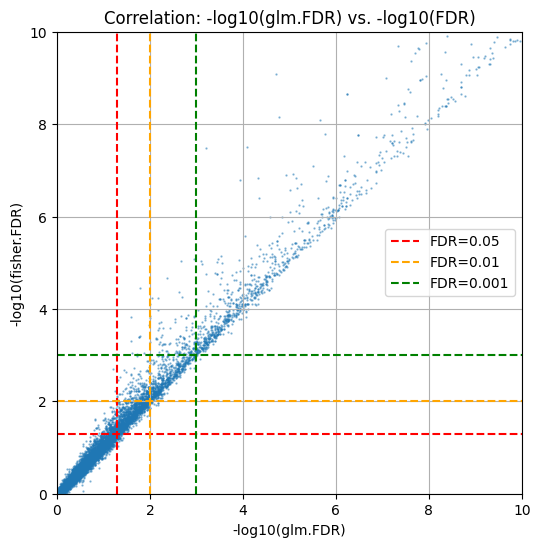

In [24]:
# Plot: Correlation between glm.FDR and FDR (log scale)
glm_fdr = detectable_cass['glm.FDR(HCT116.100%Ku_vs_10%Ku)']
fisher_fdr = detectable_cass['FDR(HCT116.100%Ku_vs_10%Ku)']

plt.figure(figsize=(6, 6))
plt.scatter(
    -np.log10(glm_fdr),
    -np.log10(fisher_fdr),
    alpha=0.5,
    s = 0.4
)
# Add cutoff lines
for fdr_thresh, color in zip([0.05, 0.01, 0.001], ['red', 'orange', 'green']):
    log_val = -np.log10(fdr_thresh)
    plt.axhline(log_val, color=color, linestyle='--', label=f'FDR={fdr_thresh}')
    plt.axvline(log_val, color=color, linestyle='--')

plt.title('Correlation: -log10(glm.FDR) vs. -log10(FDR)')
plt.xlabel('-log10(glm.FDR)')
plt.ylabel('-log10(fisher.FDR)')
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()
plt.grid(True)
plt.show()




### Figure 1a-b: Count number of Alu elements in ui, exon, di for DSEs

In [2]:
#cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.Merged.DiffAlterSplicing.results.csv")
#cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.071825.csv")
#cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/Cass.Merged.Results.csv')
cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.Ctrl.110325.csv")



detectable_cass = cass_df[(cass_df['coverage(HCT116.100%Ku_vs_0%Ku)'] > 20) | (cass_df['coverage(HCT116.10%Ku_vs_0%Ku)'] > 20)]
high_conf_cass = cass_df[cass_df['sensitivity'] == 'high']
print(len(high_conf_cass))

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_8997/1631542858.py:4: DtypeWarning: Columns (234) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.110325.csv')


967


/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_8997/1631542858.py:5: DtypeWarning: Columns (233) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.Ctrl.110325.csv")


In [3]:
# Define the row names and column mappings
row_names = [
    'Total CEs',
    'Total Detectable CEs',
    'Total DSEs',
    'Activated DSEs',
    'Repressed DSEs',
    'Ku-Bound Total CEs',
    'Ku-bound Total Detectable CEs',
    'Ku-bound Total DSEs',
    'Ku-bound Activated DSEs',
    'Ku-bound Repressed DSEs'
]

# Define the column groups
all_columns = {
    'asAlu_ui': 'all_asAlu_ui',
    'ssAlu_ui': 'all_ssAlu_ui',
    'asAlu_exon': 'all_asAlu_exon',
    'ssAlu_exon': 'all_ssAlu_exon',
    'asAlu_di': 'all_asAlu_di',
    'ssAlu_di': 'all_ssAlu_di'
}

ku_columns = {
    'asAlu_ui': 'ku_asAlu_ui',
    'ssAlu_ui': 'ku_ssAlu_ui',
    'asAlu_exon': 'ku_asAlu_exon',
    'ssAlu_exon': 'ku_ssAlu_exon',
    'asAlu_di': 'ku_asAlu_di',
    'ssAlu_di': 'ku_ssAlu_di'
}

# Initialize the results DataFrame
results = pd.DataFrame(index=row_names, columns=list(all_columns.keys()))


activated_mask = (high_conf_cass['filter(HCT116.10%Ku_vs_0%Ku)'] == 1)
repressed_mask = (high_conf_cass['filter(HCT116.10%Ku_vs_0%Ku)'] == -1)

# Populate main results
results.loc['Total CEs'] = [(cass_df[col] > 0).sum() for col in all_columns.values()]
results.loc['Total Detectable CEs'] = [(detectable_cass[col] > 0).sum() for col in all_columns.values()]
results.loc['Total DSEs'] = [(high_conf_cass[col] > 0).sum() for col in all_columns.values()]
results.loc['Activated DSEs'] = [(high_conf_cass.loc[activated_mask, col] > 0).sum() for col in all_columns.values()]
results.loc['Repressed DSEs'] = [(high_conf_cass.loc[repressed_mask, col] > 0).sum() for col in all_columns.values()]

results.loc['Ku-Bound Total CEs'] = [(cass_df[col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Total Detectable CEs'] = [(detectable_cass[col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Total DSEs'] = [(high_conf_cass[col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Activated DSEs'] = [(high_conf_cass.loc[activated_mask, col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Repressed DSEs'] = [(high_conf_cass.loc[repressed_mask, col] > 0).sum() for col in ku_columns.values()]

# --- Add intronic columns ---------------------------------------------------

results['intronic asAlu'] = [
    # Row 0: Total CEs
    ((cass_df['all_asAlu_ui'] > 0) | (cass_df['all_asAlu_di'] > 0)).sum(),

    # Row 1: Total Detectable CEs
    ((detectable_cass['all_asAlu_ui'] > 0) | (detectable_cass['all_asAlu_di'] > 0)).sum(),

    # Row 2: Total DSEs
    ((high_conf_cass['all_asAlu_ui'] > 0) | (high_conf_cass['all_asAlu_di'] > 0)).sum(),

    # Row 3: Activated DSEs
    ((high_conf_cass.loc[activated_mask, 'all_asAlu_ui'] > 0) |
     (high_conf_cass.loc[activated_mask, 'all_asAlu_di'] > 0)).sum(),

    # Row 4: Repressed DSEs
    ((high_conf_cass.loc[repressed_mask, 'all_asAlu_ui'] > 0) |
     (high_conf_cass.loc[repressed_mask, 'all_asAlu_di'] > 0)).sum(),

    # Row 5: Ku-Bound Total CEs
    #((cass_df['ku_bound'] == 1) &
    #((cass_df['ku_asAlu_ui'] > 0) | (cass_df['ku_asAlu_di'] > 0))
    #).sum(),

    ((cass_df['ku_asAlu_ui'] > 0) | (cass_df['ku_asAlu_di'] > 0)).sum(),

    # Row 6: Ku-bound Detectable CEs
    #((detectable_cass['ku_bound'] == 1) &
    #((detectable_cass['ku_asAlu_ui'] > 0) | (detectable_cass['ku_asAlu_di'] > 0))
    #).sum(),
    ((detectable_cass['ku_asAlu_ui'] > 0) | (detectable_cass['ku_asAlu_di'] > 0)).sum(),

    # Row 7: Ku-bound Total DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_asAlu_di'] > 0))
    #).sum(),
    ((high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_asAlu_di'] > 0)).sum(),

    # Row 8: Ku-bound Activated DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass.loc[activated_mask, 'ku_asAlu_ui'] > 0) |
    #(high_conf_cass.loc[activated_mask, 'ku_asAlu_di'] > 0))
    #).sum(),
    ((high_conf_cass.loc[activated_mask, 'ku_asAlu_ui'] > 0) |
    (high_conf_cass.loc[activated_mask, 'ku_asAlu_di'] > 0)).sum(),

    # Row 9: Ku-bound Repressed DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass.loc[repressed_mask, 'ku_asAlu_ui'] > 0) |
    #(high_conf_cass.loc[repressed_mask, 'ku_asAlu_di'] > 0))
    #).sum()
    ((high_conf_cass.loc[repressed_mask, 'ku_asAlu_ui'] > 0) |
    (high_conf_cass.loc[repressed_mask, 'ku_asAlu_di'] > 0)).sum()
]


results['intronic ssAlu'] = [
    # Row 0: Total CEs
    ((cass_df['all_ssAlu_ui'] > 0) | (cass_df['all_ssAlu_di'] > 0)).sum(),

    # Row 1: Total Detectable CEs
    ((detectable_cass['all_ssAlu_ui'] > 0) | (detectable_cass['all_ssAlu_di'] > 0)).sum(),

    # Row 2: Total DSEs
    ((high_conf_cass['all_ssAlu_ui'] > 0) | (high_conf_cass['all_ssAlu_di'] > 0)).sum(),

    # Row 3: Activated DSEs
    ((high_conf_cass.loc[activated_mask, 'all_ssAlu_ui'] > 0) |
     (high_conf_cass.loc[activated_mask, 'all_ssAlu_di'] > 0)).sum(),

    # Row 4: Repressed DSEs
    ((high_conf_cass.loc[repressed_mask, 'all_ssAlu_ui'] > 0) |
     (high_conf_cass.loc[repressed_mask, 'all_ssAlu_di'] > 0)).sum(),

    # Row 5: Ku-Bound Total CEs
    #((cass_df['ku_bound'] == 1) &
    #((cass_df['ku_ssAlu_ui'] > 0) | (cass_df['ku_ssAlu_di'] > 0))
    #).sum(),
    ((cass_df['ku_ssAlu_ui'] > 0) | (cass_df['ku_ssAlu_di'] > 0)).sum(),

    # Row 6: Ku-bound Detectable CEs
    #((detectable_cass['ku_bound'] == 1) &
    #((detectable_cass['ku_ssAlu_ui'] > 0) | (detectable_cass['ku_ssAlu_di'] > 0))
    #).sum(),
    ((detectable_cass['ku_ssAlu_ui'] > 0) | (detectable_cass['ku_ssAlu_di'] > 0)).sum(),

    # Row 7: Ku-bound Total DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass['ku_ssAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0))
    #).sum(),
    ((high_conf_cass['ku_ssAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0)).sum(),

    # Row 8: Ku-bound Activated DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass.loc[activated_mask, 'ku_ssAlu_ui'] > 0) |
    #(high_conf_cass.loc[activated_mask, 'ku_ssAlu_di'] > 0))
    #).sum(),
    ((high_conf_cass.loc[activated_mask, 'ku_ssAlu_ui'] > 0) |
    (high_conf_cass.loc[activated_mask, 'ku_ssAlu_di'] > 0)).sum(),

    # Row 9: Ku-bound Repressed DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass.loc[repressed_mask, 'ku_ssAlu_ui'] > 0) |
    #(high_conf_cass.loc[repressed_mask, 'ku_ssAlu_di'] > 0))
    #).sum()
    ((high_conf_cass.loc[repressed_mask, 'ku_ssAlu_ui'] > 0) |
    (high_conf_cass.loc[repressed_mask, 'ku_ssAlu_di'] > 0)).sum()
]

results['intronic Alu'] = [
    # Row 0: Total CEs
    ((cass_df['all_ssAlu_ui'] > 0) | (cass_df['all_ssAlu_di'] > 0) | (cass_df['all_asAlu_ui'] > 0) | (cass_df['all_asAlu_di'] > 0)).sum(),

    # Row 1: Total Detectable CEs
    ((detectable_cass['all_ssAlu_ui'] > 0) | (detectable_cass['all_ssAlu_di'] > 0) | (detectable_cass['all_asAlu_ui'] > 0) | (detectable_cass['all_asAlu_di'] > 0)).sum(),

    # Row 2: Total DSEs
    ((high_conf_cass['all_ssAlu_ui'] > 0) | (high_conf_cass['all_ssAlu_di'] > 0) | (high_conf_cass['all_asAlu_ui'] > 0) | (high_conf_cass['all_asAlu_di'] > 0)).sum(),

    # Row 3: Activated DSEs
    ((high_conf_cass.loc[activated_mask, 'all_ssAlu_ui'] > 0) |
     (high_conf_cass.loc[activated_mask, 'all_ssAlu_di'] > 0) |
     (high_conf_cass.loc[activated_mask, 'all_asAlu_ui'] > 0) |
     (high_conf_cass.loc[activated_mask, 'all_asAlu_di'] > 0)).sum(),

    # Row 4: Repressed DSEs
    ((high_conf_cass.loc[repressed_mask, 'all_ssAlu_ui'] > 0) |
     (high_conf_cass.loc[repressed_mask, 'all_ssAlu_di'] > 0) |
     (high_conf_cass.loc[repressed_mask, 'all_asAlu_ui'] > 0) |
     (high_conf_cass.loc[repressed_mask, 'all_asAlu_di'] > 0)).sum(),

    # Row 5: Ku-Bound Total CEs
    #((cass_df['ku_bound'] == 1) &
    #((cass_df['ku_ssAlu_ui'] > 0) | (cass_df['ku_ssAlu_di'] > 0) | (cass_df['ku_asAlu_ui'] > 0) | (cass_df['ku_asAlu_di'] > 0))
    #).sum(),
    ((cass_df['ku_ssAlu_ui'] > 0) | (cass_df['ku_ssAlu_di'] > 0) | (cass_df['ku_asAlu_ui'] > 0) | (cass_df['ku_asAlu_di'] > 0)).sum(),

    # Row 6: Ku-bound Detectable CEs
    #((detectable_cass['ku_bound'] == 1) &
    #((detectable_cass['ku_ssAlu_ui'] > 0) | (detectable_cass['ku_ssAlu_di'] > 0) | (detectable_cass['ku_asAlu_ui'] > 0) | (detectable_cass['ku_asAlu_di'] > 0))
    #).sum(),
    ((detectable_cass['ku_ssAlu_ui'] > 0) | (detectable_cass['ku_ssAlu_di'] > 0) | (detectable_cass['ku_asAlu_ui'] > 0) | (detectable_cass['ku_asAlu_di'] > 0)).sum(),

    # Row 7: Ku-bound Total DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass['ku_ssAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0) | (high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_asAlu_di'] > 0))
    #).sum(),
    ((high_conf_cass['ku_ssAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0) | (high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_asAlu_di'] > 0)).sum(),

    # Row 8: Ku-bound Activated DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass.loc[activated_mask, 'ku_ssAlu_ui'] > 0) |
    #(high_conf_cass.loc[activated_mask, 'ku_ssAlu_di'] > 0) |
    #(high_conf_cass.loc[activated_mask, 'ku_asAlu_ui'] > 0) |
    #(high_conf_cass.loc[activated_mask, 'ku_asAlu_di'] > 0))
    #).sum(),
    ((high_conf_cass.loc[activated_mask, 'ku_ssAlu_ui'] > 0) |
    (high_conf_cass.loc[activated_mask, 'ku_ssAlu_di'] > 0) |
    (high_conf_cass.loc[activated_mask, 'ku_asAlu_ui'] > 0) |
    (high_conf_cass.loc[activated_mask, 'ku_asAlu_di'] > 0)).sum(),

    # Row 9: Ku-bound Repressed DSEs
    #((high_conf_cass['ku_bound'] == 1) &
    #((high_conf_cass.loc[repressed_mask, 'ku_ssAlu_ui'] > 0) |
    #(high_conf_cass.loc[repressed_mask, 'ku_ssAlu_di'] > 0) |
    #(high_conf_cass.loc[repressed_mask, 'ku_asAlu_ui'] > 0) |
    #(high_conf_cass.loc[repressed_mask, 'ku_asAlu_di'] > 0)) 
    #).sum()
    ((high_conf_cass.loc[repressed_mask, 'ku_ssAlu_ui'] > 0) |
    (high_conf_cass.loc[repressed_mask, 'ku_ssAlu_di'] > 0) |
    (high_conf_cass.loc[repressed_mask, 'ku_asAlu_ui'] > 0) |
    (high_conf_cass.loc[repressed_mask, 'ku_asAlu_di'] > 0)).sum()
]



# Revised 'no_Alu' calculations with corrected Ku-bound logic
results['no_Alu'] = [
    # Row 0: Total CEs (all columns)
    (cass_df[list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 1: Total Detectable CEs (all columns)
    (detectable_cass[list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 2: Total DSEs (all columns)
    (high_conf_cass[list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 3: Activated DSEs (all columns)
    (high_conf_cass.loc[activated_mask, list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 4: Repressed DSEs (all columns)
    (high_conf_cass.loc[repressed_mask, list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 5: Ku-Bound Total CEs - Alu-free in ALL columns AND ku_columns
    ((cass_df['ku_bound'] == 1) &
    (cass_df[list(all_columns.values())] == 0).all(axis=1) & 
     (cass_df[list(ku_columns.values())] == 0).all(axis=1)
    ).sum(),
    
    # Row 6: Ku-bound Detectable CEs - Alu-free in ALL columns AND ku_columns (from detectable_cass)
    (((detectable_cass['ku_bound'] == 1) &
    (detectable_cass[list(all_columns.values())] == 0).all(axis=1) &
    (detectable_cass[list(ku_columns.values())] == 0).all(axis=1)
    ).sum()),

    # Row 7: Ku-bound DSEs - Alu-free in ALL columns AND ku_columns (from high_conf_cass)
    (((high_conf_cass['ku_bound'] == 1) &
    (high_conf_cass[list(all_columns.values())] == 0).all(axis=1) &
    (high_conf_cass[list(ku_columns.values())] == 0).all(axis=1)
    ).sum()),

    # Row 8: Ku-bound Activated DSEs - Alu-free in ALL columns AND ku_columns (activated subset)
    (((high_conf_cass.loc[activated_mask, 'ku_bound'] == 1) &
    (high_conf_cass.loc[activated_mask, list(all_columns.values())] == 0).all(axis=1) &
    (high_conf_cass.loc[activated_mask, list(ku_columns.values())] == 0).all(axis=1)
    ).sum()),

    # Row 9: Ku-bound Repressed DSEs - Alu-free in ALL columns AND ku_columns (repressed subset)
    (((high_conf_cass.loc[repressed_mask, 'ku_bound'] == 1) &
    (high_conf_cass.loc[repressed_mask, list(all_columns.values())] == 0).all(axis=1) &
    (high_conf_cass.loc[repressed_mask, list(ku_columns.values())] == 0).all(axis=1)
    ).sum())
]

# Add 'Total Samples' column
results['Total Samples'] = [
    len(cass_df),  # Total CEs
    len(detectable_cass),  # Total Detectable CEs
    len(high_conf_cass),  # Total DSEs
    activated_mask.sum(),  # Activated DSEs
    repressed_mask.sum(),  # Repressed DSEs
    # Ku-Bound Total CEs
    #(cass_df['ku_bound'] == 1).sum(),
    ((cass_df['ku_asAlu_exon'] > 0) | (cass_df['ku_ssAlu_exon'] > 0) |
     (cass_df['ku_asAlu_ui'] > 0) | (cass_df['ku_ssAlu_ui'] > 0) |
     (cass_df['ku_asAlu_di'] > 0) | (cass_df['ku_ssAlu_di'] > 0)).sum(),

    # Ku-bound Total Detectable CEs
    #(detectable_cass['ku_bound'] == 1).sum(),
    ((detectable_cass['ku_asAlu_exon'] > 0) | (detectable_cass['ku_ssAlu_exon'] > 0) |
     (detectable_cass['ku_asAlu_ui'] > 0) | (detectable_cass['ku_ssAlu_ui'] > 0) |
     (detectable_cass['ku_asAlu_di'] > 0) | (detectable_cass['ku_ssAlu_di'] > 0)).sum(),

    # Ku-bound Total DSEs
    #(high_conf_cass['ku_bound'] == 1).sum(),
    ((high_conf_cass['ku_asAlu_exon'] > 0) | (high_conf_cass['ku_ssAlu_exon'] > 0) |
     (high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_ui'] > 0) |
     (high_conf_cass['ku_asAlu_di'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0)).sum(),

    # Ku-bound Activated DSEs
    #((high_conf_cass['ku_bound'] == 1) & activated_mask).sum(),
    (((high_conf_cass['ku_asAlu_exon'] > 0) | (high_conf_cass['ku_ssAlu_exon'] > 0) |
     (high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_ui'] > 0) |
     (high_conf_cass['ku_asAlu_di'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0)) & 
     activated_mask).sum(),


    # Ku-bound Repressed DSEs
    #((high_conf_cass['ku_bound'] == 1) & repressed_mask).sum()
    (((high_conf_cass['ku_asAlu_exon'] > 0) | (high_conf_cass['ku_ssAlu_exon'] > 0) |
     (high_conf_cass['ku_asAlu_ui'] > 0) | (high_conf_cass['ku_ssAlu_ui'] > 0) |
     (high_conf_cass['ku_asAlu_di'] > 0) | (high_conf_cass['ku_ssAlu_di'] > 0)) & 
     repressed_mask).sum(),
]

#output_dir = '/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/Alu Tag Count/'
#os.makedirs(output_dir, exist_ok=True)
#results.to_csv(f'{output_dir}/new.Alu_Tag_Count.csv')

In [7]:
results

,asAlu_ui,ssAlu_ui,asAlu_exon,ssAlu_exon,asAlu_di,ssAlu_di,intronic asAlu,intronic ssAlu,intronic Alu,no_Alu,Total Samples
Total CEs,20695,19811,2678,440,20605,19891,28527,28132,32599,9859,42761
Total Detectable CEs,9643,9218,1238,172,9620,9199,13326,13054,15136,4558,19827
Total DSEs,469,397,158,7,481,403,691,625,742,205,967
Activated DSEs,222,181,9,3,232,198,312,289,322,66,390
Repressed DSEs,247,216,149,4,249,205,379,336,420,139,577
Ku-Bound Total CEs,2516,37,56,0,2014,45,4155,82,4207,0,4238
Ku-bound Total Detectable CEs,1488,17,33,0,1168,32,2443,49,2472,0,2490
Ku-bound Total DSEs,61,0,8,0,72,3,124,3,125,0,131
Ku-bound Activated DSEs,24,0,0,0,31,3,49,3,50,0,50
Ku-bound Repressed DSEs,37,0,8,0,41,0,75,0,75,0,81


In [ ]:
# with condition Ku_bound == 1 for all Ku-bound samples
results

,asAlu_ui,ssAlu_ui,asAlu_exon,ssAlu_exon,asAlu_di,ssAlu_di,intronic asAlu,intronic ssAlu,intronic Alu,no_Alu,Total Samples
Total CEs,20695,19811,2678,440,20605,19891,28527,28132,32599,9859,42761
Total Detectable CEs,9643,9218,1238,172,9620,9199,13326,13054,15136,4558,19827
Total DSEs,469,397,158,7,481,403,691,625,742,205,967
Activated DSEs,222,181,9,3,232,198,312,289,322,66,390
Repressed DSEs,247,216,149,4,249,205,379,336,420,139,577
Ku-Bound Total CEs,14871,37,1329,0,14241,45,20642,79,20652,0,20939
Ku-bound Total Detectable CEs,7791,17,744,0,7449,32,10827,48,10831,0,10992
Ku-bound Total DSEs,384,0,116,0,395,3,561,3,561,0,586
Ku-bound Activated DSEs,176,0,6,0,177,3,261,3,261,0,261
Ku-bound Repressed DSEs,208,0,110,0,218,0,300,0,300,0,325


In [8]:
results

,asAlu_ui,ssAlu_ui,asAlu_exon,ssAlu_exon,asAlu_di,ssAlu_di,intronic asAlu,intronic ssAlu,no_Alu,Total Samples
Total CEs,20695,19811,2678,440,20605,19891,28527,28132,9859,42761
Total Detectable CEs,9643,9218,1238,172,9620,9199,13326,13054,4558,19827
Total DSEs,469,397,158,7,481,403,691,625,205,967
Activated DSEs,222,181,9,3,232,198,312,289,66,390
Repressed DSEs,247,216,149,4,249,205,379,336,139,577
Ku-Bound Total CEs,14871,37,1329,0,14241,45,20642,79,0,20939
Ku-bound Total Detectable CEs,7791,17,744,0,7449,32,10827,48,0,10992
Ku-bound Total DSEs,384,0,116,0,395,3,561,3,0,586
Ku-bound Activated DSEs,176,0,6,0,177,3,261,3,0,261
Ku-bound Repressed DSEs,208,0,110,0,218,0,300,0,0,325


In [ ]:
filtered = high_conf_cass[
    (high_conf_cass['filter(HCT116.10%Ku_vs_0%Ku)'] == -1) &
    (high_conf_cass['all_asAlu_ui'] == 0) &
    (high_conf_cass['all_asAlu_ui_old'] > 0)
]

print(filtered['name'])

#### Count for G1 Arrest HCT116 samples

In [ ]:
#cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.Merged.DiffAlterSplicing.results.csv")
cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.071825.csv")
detectable_cass = cass_df[cass_df['coverage(G1Arr.HCT116.KuKD)'] > 20]
print(len(detectable_cass))
high_conf_cass = cass_df[cass_df['filter(G1Arr.HCT116.KuKD)'].isin([1,-1])]
print(len(high_conf_cass))
print(len(high_conf_cass[high_conf_cass['filter(G1Arr.HCT116.KuKD)'] == -1]))
print(len(high_conf_cass[high_conf_cass['filter(G1Arr.HCT116.KuKD)'] == 1]))
# Initialize the results DataFrame
results = pd.DataFrame(index=row_names, columns=list(all_columns.keys()))


activated_mask = (high_conf_cass['filter(G1Arr.HCT116.KuKD)'] == 1)
repressed_mask = (high_conf_cass['filter(G1Arr.HCT116.KuKD)'] == -1)

# Populate main results
results.loc['Total CEs'] = [(cass_df[col] > 0).sum() for col in all_columns.values()]
results.loc['Total Detectable CEs'] = [(detectable_cass[col] > 0).sum() for col in all_columns.values()]
results.loc['Total DSEs'] = [(high_conf_cass[col] > 0).sum() for col in all_columns.values()]
results.loc['Activated DSEs'] = [(high_conf_cass.loc[activated_mask, col] > 0).sum() for col in all_columns.values()]
results.loc['Repressed DSEs'] = [(high_conf_cass.loc[repressed_mask, col] > 0).sum() for col in all_columns.values()]

results.loc['Ku-Bound Total CEs'] = [(cass_df[col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Total Detectable CEs'] = [(detectable_cass[col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Total DSEs'] = [(high_conf_cass[col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Activated DSEs'] = [(high_conf_cass.loc[activated_mask, col] > 0).sum() for col in ku_columns.values()]
results.loc['Ku-bound Repressed DSEs'] = [(high_conf_cass.loc[repressed_mask, col] > 0).sum() for col in ku_columns.values()]


# Revised 'no_Alu' calculations with corrected Ku-bound logic
results['no_Alu'] = [
    # Row 0: Total CEs (all columns)
    (cass_df[list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 1: Total Detectable CEs (all columns)
    (detectable_cass[list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 2: Total DSEs (all columns)
    (high_conf_cass[list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 3: Activated DSEs (all columns)
    (high_conf_cass.loc[activated_mask, list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 4: Repressed DSEs (all columns)
    (high_conf_cass.loc[repressed_mask, list(all_columns.values())] == 0).all(axis=1).sum(),
    
    # Row 5: Ku-Bound Total CEs - Alu-free in ALL columns AND ku_columns
    ((cass_df[list(all_columns.values())] == 0).all(axis=1) & 
     (cass_df[list(ku_columns.values())] == 0).all(axis=1)
    ).sum(),
    
    # Row 6: Ku-bound Detectable CEs - Alu-free in ALL columns AND ku_columns (from detectable_cass)
    ((detectable_cass[list(all_columns.values())] == 0).all(axis=1) & 
     (detectable_cass[list(ku_columns.values())] == 0).all(axis=1)
    ).sum(),
    
    # Row 7: Ku-bound DSEs - Alu-free in ALL columns AND ku_columns (from high_conf_cass)
    ((high_conf_cass[list(all_columns.values())] == 0).all(axis=1) & 
     (high_conf_cass[list(ku_columns.values())] == 0).all(axis=1)
    ).sum(),
    
    # Row 8: Ku-bound Activated DSEs - Alu-free in ALL columns AND ku_columns (activated subset)
    ((high_conf_cass.loc[activated_mask, list(all_columns.values())] == 0).all(axis=1) & 
     (high_conf_cass.loc[activated_mask, list(ku_columns.values())] == 0).all(axis=1)
    ).sum(),
    
    # Row 9: Ku-bound Repressed DSEs - Alu-free in ALL columns AND ku_columns (repressed subset)
    ((high_conf_cass.loc[repressed_mask, list(all_columns.values())] == 0).all(axis=1) & 
     (high_conf_cass.loc[repressed_mask, list(ku_columns.values())] == 0).all(axis=1)
    ).sum()
]

# Add 'Total Samples' column
results['Total Samples'] = [
    len(cass_df),  # Total CEs
    len(detectable_cass),  # Total Detectable CEs
    len(high_conf_cass),  # Total DSEs
    activated_mask.sum(),  # Activated DSEs
    repressed_mask.sum(),  # Repressed DSEs
    len(cass_df),  # Ku-Bound Total CEs
    len(detectable_cass),  # Ku-bound Total Detectable CEs
    len(high_conf_cass),  # Ku-bound Total DSEs
    activated_mask.sum(),  # Ku-bound Activated DSEs
    repressed_mask.sum()  # Ku-bound Repressed DSEs
]

7197
258
114
144


/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/101490453.py:2: DtypeWarning: Columns (229) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DASE_Results/Cass.AluOverlap.071825.csv")


In [10]:
results

,asAlu_ui,ssAlu_ui,asAlu_exon,ssAlu_exon,asAlu_di,ssAlu_di,no_Alu,Total Samples
Total CEs,20695,19811,2678,440,20605,19891,9859,42761
Total Detectable CEs,3512,3348,539,58,3619,3445,1588,7197
Total DASEs,151,107,58,2,119,108,39,258
Activated DASEs,91,65,4,1,67,74,24,144
Repressed DASEs,60,42,54,1,52,34,15,114
Ku-Bound Total CEs,14871,37,1329,0,14241,45,9859,42761
Ku-bound Total Detectable CEs,2923,7,347,0,2906,11,1588,7197
Ku-bound Total DASEs,138,0,51,0,100,1,39,258
Ku-bound Activated DASEs,85,0,4,0,56,1,24,144
Ku-bound Repressed DASEs,53,0,47,0,44,0,15,114


In [11]:
output_dir = '/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/Alu Tag Count/'
os.makedirs(output_dir, exist_ok=True)
results.to_csv(f'{output_dir}/new.G1Arrest.Alu_Tag_Count.csv')

### Create DSE count table

In [ ]:
# Define the directory containing the files
input_dir = "/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results"

# Define file names corresponding to their types
file_names = {
    "cass": "Cass.Merged.DiffAlterSplicing.results.csv",
    "alt3": "Alt3.Merged.DiffAlterSplicing.results.csv",
    "alt5": "Alt5.Merged.DiffAlterSplicing.results.csv",
    "iret": "Iret.Merged.DiffAlterSplicing.results.csv",
    "mutx": "Mutx.Merged.DiffAlterSplicing.results.csv",
    "taca": "Taca.Merged.DiffAlterSplicing.results.csv"
}

#cass_df = pd.read_csv(os.path.join(input_dir, file_names['cass']))
cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.071825.csv')
sig_cass_df = cass_df[(cass_df['coverage(HCT116.100%Ku_vs_0%Ku)'] > 20) | (cass_df['coverage(HCT116.10%Ku_vs_0%Ku)'] > 20)]
print(len(sig_cass_df))

19827


/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/4163045870.py:15: DtypeWarning: Columns (230) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DASE_Results/Cass.AluOverlap.071825.csv')


In [29]:
#sig_cass_df['sensitivity'].isin(['high','low','middle']).sum()
sig_cass_df['sensitivity'].isin(['high']).sum()

967

In [ ]:
def fig1_count_DSE_old(df):
    total_DSE_df = df[df['sensitivity'].isin(['high','middle','low'])]
    high_sense_df = df[df['sensitivity'] == 'high']
    middle_sense_df = df[df['sensitivity'] == 'middle']
    low_sense_df = df[df['sensitivity'] == 'low']
    non_DSE_df = df[~df['sensitivity'].isin(['high', 'middle', 'low'])]

    print(f"Total number number of significant samples: {len(df)}. \nWithin which, {len(non_DSE_df)} are non-DSEs,  {len(total_DSE_df)} are DSEs")
    print(f"Total number of DSEs: {len(total_DSE_df)}")
    print(f"Number of high Ku sensitive samples: {len(high_sense_df)} \nNumber of middle Ku sensitive samples: {len(middle_sense_df)} \nNumber of low Ku sensitive samples: {len(low_sense_df)}\n")

def build_count_table(df, sensitivity_level, alu_type_col, FDR_cutoff = 0.05, dI_cutoff = 0.1):
        alu_types = df[alu_type_col].unique()
        alu_types = sorted(alu_types)
        table = pd.DataFrame(
            index=['total', 'no change', 'activated cass exon', 'repressed cass exon',
                   'ku bound total','ku bound no change','ku bound activated cass exon','ku bound repressed cass exon'],
            columns=alu_types
        ).fillna(0)
        
        for alu in alu_types:
            alu_subset = df[df[alu_type_col] == alu] # all detectable CEs in 'alutype'
            FDR_sig_condition_for_high_conf = (
                (alu_subset['FDR(HCT116.100%Ku_vs_0%Ku)'] < FDR_cutoff) &
                (alu_subset['FDR(HCT116.10%Ku_vs_0%Ku)'] < FDR_cutoff)
                )
            FDR_sig_condition_for_low_conf = (
                (alu_subset['FDR(HCT116.100%Ku_vs_0%Ku)'] < FDR_cutoff) |
                (alu_subset['FDR(HCT116.10%Ku_vs_0%Ku)'] < FDR_cutoff)
                )
            dI_sig_condition_for_high_conf = (
                (np.abs(alu_subset['dI_g1_vs_g2(HCT116.100%Ku_vs_0%Ku)']) > dI_cutoff) &
                (np.abs(alu_subset['dI_g1_vs_g2(HCT116.10%Ku_vs_0%Ku)']) > dI_cutoff)
                )
            dI_sig_condition_for_low_conf = (
                (np.abs(alu_subset['dI_g1_vs_g2(HCT116.100%Ku_vs_0%Ku)']) > dI_cutoff) |
                (np.abs(alu_subset['dI_g1_vs_g2(HCT116.10%Ku_vs_0%Ku)']) > dI_cutoff)
                )
            n_total = len(alu_subset)
            n_total_ku_bound = (alu_subset['ku_bound'] == 1).sum() # number of detectable CEs bound by Ku
            table.loc['total', alu] = n_total # fill the total row
            table.loc['ku bound total', alu] = n_total_ku_bound # fill the ku bound total
            
            if sensitivity_level == 'high':
                high_sens_alu_subset = alu_subset[(alu_subset['sensitivity'] == 'high') & FDR_sig_condition_for_high_conf & dI_sig_condition_for_high_conf] # all DSEs occur in both conditions in 'alutype'
                n_nochange = n_total - len(high_sens_alu_subset) # number of nonDSEs in 'alutype', including low and middle confident samples

                n_DSEs_bound_by_ku = (high_sens_alu_subset['ku_bound'] == 1).sum() # number of Ku bound DSEs in both conditions in 'alutype'
                n_nochange_ku_bound = n_total_ku_bound - n_DSEs_bound_by_ku # number of Ku bound nonDSEs in 'alutype', including low and middle confident samples
                print(f'total number of high confidence DSEs (FDR < {FDR_cutoff}) in {alu}: {len(high_sens_alu_subset)}')

                # High sensitivity: Only consider 10%Ku filter
                activated = (high_sens_alu_subset['filter(HCT116.100%Ku_vs_0%Ku)'] == 1).sum()
                repressed = (high_sens_alu_subset['filter(HCT116.100%Ku_vs_0%Ku)'] == -1).sum()
                
                ku_bound_activated = ((high_sens_alu_subset['filter(HCT116.100%Ku_vs_0%Ku)'] == 1) & 
                             (high_sens_alu_subset['ku_bound'] == 1)).sum()
                ku_bound_repressed = ((high_sens_alu_subset['filter(HCT116.100%Ku_vs_0%Ku)'] == -1) & 
                             (high_sens_alu_subset['ku_bound'] == 1)).sum()
                
                if (activated+repressed) != len(high_sens_alu_subset):
                    raise ValueError(f"Total number of activated and repressed DSEs not equal to total number of DSEs in high confidence {alu} type") 
                elif (ku_bound_activated + ku_bound_repressed) != n_DSEs_bound_by_ku:
                    raise ValueError(f"Total number of Ku-BOUND activated and repressed DSEs not equal to total number of DSEs in high confidence {alu} type") 
            elif sensitivity_level == 'total':
                total_alu_DSE_subset = alu_subset[
                    ((alu_subset['sensitivity'].isin(['middle', 'low'])) & FDR_sig_condition_for_low_conf & dI_sig_condition_for_low_conf) |
                    ((alu_subset['sensitivity'] == 'high') & FDR_sig_condition_for_high_conf & dI_sig_condition_for_high_conf)]

                print(f'total number of low and high confidence DAES (FDR < {FDR_cutoff}) in {alu} is {len(total_alu_DSE_subset)} ')
                n_nochange = n_total - len(total_alu_DSE_subset)

                n_total_alu_DSEs_ku_bound = ((total_alu_DSE_subset['ku_bound'] == 1)).sum()
                n_nochange_ku_bound = n_total_ku_bound - n_total_alu_DSEs_ku_bound

                cond_10 = total_alu_DSE_subset['filter(HCT116.10%Ku_vs_0%Ku)']
                cond_100 = total_alu_DSE_subset['filter(HCT116.100%Ku_vs_0%Ku)']
                
                activated = ((cond_10 == 1) | (cond_100 == 1)).sum()
                repressed = ((cond_10 == -1) | (cond_100 == -1)).sum()
                
                # Check if there's any outliers (i.e. high confidence but different dI directions)
                mask = (((cond_10 == 1) | (cond_100 == 1)) & ((cond_10 == -1) | (cond_100 == -1)))
                outliers = total_alu_DSE_subset[mask]
                if len(outliers) != 0:
                    print(f'outlier is {outliers['name']}')

                ku_bound_activated = (((cond_10 == 1) | (cond_100 == 1)) & 
                                      (total_alu_DSE_subset['ku_bound'] == 1)).sum()
                ku_bound_repressed = (((cond_10 == -1) | (cond_100 == -1)) & 
                                      (total_alu_DSE_subset['ku_bound'] == 1)).sum() 
                
                if (activated+repressed) != len(total_alu_DSE_subset):
                    raise ValueError(f"Total number of activated and repressed DSEs not equal to total number of DSEs in low confidence {alu} type \nWe have activated {activated}, repressed {repressed}, total DSEs {len(total_alu_DSE_subset)}") 
                elif (ku_bound_activated + ku_bound_repressed) != n_total_alu_DSEs_ku_bound:
                    raise ValueError(f"Total number of Ku-BOUND activated and repressed DSEs not equal to total number of DSEs in low confidence {alu} type") 
            else:
                raise IndexError("Input for sensitivity_level should be 'high' or 'total'. ")

            
            table.loc['no change', alu] = n_nochange
            table.loc['activated cass exon', alu] = activated
            table.loc['repressed cass exon', alu] = repressed
            table.loc['ku bound no change', alu] = n_nochange_ku_bound
            table.loc['ku bound activated cass exon', alu] = ku_bound_activated
            table.loc['ku bound repressed cass exon', alu] = ku_bound_repressed
        
        return table

def fig1_count_DSE(df, alu_type_col = 'alu_type', FDR_sig_cutoff = 0.05, dI_sig_cutoff = 0.1, verbose = False):
    if verbose:
        # Filter datasets by sensitivity
        total_DSE_subset = df[df['sensitivity'].isin(['high', 'middle', 'low'])]
        high_sense_subset = df[df['sensitivity'] == 'high']
        middle_sense_subset = df[df['sensitivity'] == 'middle']
        low_sense_subset = df[df['sensitivity'] == 'low']
        non_DSE_df = df[~df['sensitivity'].isin(['high', 'middle', 'low'])]

        
        # Print counts
        print(f"Total number number of detactable samples (coverage > 20 in both conditions): {len(df)}. \nWithin which, {len(non_DSE_df)} are non-DSEs,  {len(total_DSE_subset)} are DSEs")
        print(f"Number of high Ku sensitive samples: {len(high_sense_subset)} \nNumber of middle Ku sensitive samples: {len(middle_sense_subset)} \nNumber of low Ku sensitive samples: {len(low_sense_subset)}\n")
    

    high_conf_df = build_count_table(df, 'high', alu_type_col, FDR_sig_cutoff, dI_sig_cutoff)
    total_conf_df = build_count_table(df, 'total', alu_type_col, FDR_sig_cutoff, dI_sig_cutoff)
    
    return total_conf_df, high_conf_df


In [ ]:
############### For AluType ###############
"""Count among all significant cassette exons"""
total_DSE_count, high_sense_DSE_count = fig1_count_DSE(sig_cass_df, FDR_sig_cutoff = 0.05)
print('total DSEs')
print(total_DSE_count)
print('\nhigh Ku sensitive DSEs')
print(high_sense_DSE_count)

"""Count among all alu-dependent DSEs"""
alu_dependent_cass_df = sig_cass_df[sig_cass_df['alu_type'].isin(['asAlu','irAlu','ssAlu'])]
#fig1_count_DSE_old(alu_dependent_cass_df)
alu_total_DSE_count, alu_high_sense_DSE_count = fig1_count_DSE(alu_dependent_cass_df, FDR_sig_cutoff = 0.05)
#print('total alu-dependent DSEs')
#print(alu_total_DSE_count)
#print('\nhigh Ku sensitive DSEs')
#print(alu_high_sense_DSE_count)
#print('\nmiddle Ku sensitive DSEs')
#print(alu_middle_sense_DSE_count)
#print('\nlow Ku sensitive DSEs')
#print(alu_low_sense_DSE_count)
#print('\nNon-DSEs')
#print(alu_non_DSE_count)

"""Count among all brain-specific significant cassette exons"""
brain_specific_cass_df = sig_cass_df[sig_cass_df['FDR(ttest)'] < 0.05]
fig1_count_DSE_old(brain_specific_cass_df)
brain_total_DSE_count, brain_high_sense_DSE_count = fig1_count_DSE(brain_specific_cass_df, FDR_sig_cutoff = 0.05)
#print('total brain-specific DSEs')
#print(brain_total_DSE_count)
#print('\nhigh Ku sensitive DSEs')
#print(brain_high_sense_DSE_count)

total number of high confidence DASEs (FDR < 0.05) in asAlu: 158
total number of high confidence DASEs (FDR < 0.05) in irAlu: 312
total number of high confidence DASEs (FDR < 0.05) in other: 490
total number of high confidence DASEs (FDR < 0.05) in ssAlu: 7
total number of low and high confidence DAES (FDR < 0.05) in asAlu is 277 
total number of low and high confidence DAES (FDR < 0.05) in irAlu is 860 
total number of low and high confidence DAES (FDR < 0.05) in other is 1482 
total number of low and high confidence DAES (FDR < 0.05) in ssAlu is 17 
total dases
                              asAlu  irAlu  other  ssAlu
total                          1238   7072  11357    160
no change                       961   6212   9875    143
activated cass exon              29    548    538     10
repressed cass exon             248    312    944      7
ku bound total                  744   6257   3991      0
ku bound no change              569   5506   3443      0
ku bound activated cass exon   

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future

In [ ]:
FDR_sig_cutoff = 0.05
output_dir = '/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/DSE/AluType'
os.makedirs(output_dir, exist_ok=True)

total_DSE_count.to_csv(f'{output_dir}/FDR{FDR_sig_cutoff}_AluType_total_DSE_count.csv')
high_sense_DSE_count.to_csv(f'{output_dir}/FDR{FDR_sig_cutoff}_AluType_high_sense_DSE_count.csv')

brain_total_DSE_count.to_csv(f'{output_dir}/FDR{FDR_sig_cutoff}_AluType_brain_total_DSE_count.csv')
brain_high_sense_DSE_count.to_csv(f'{output_dir}/FDR{FDR_sig_cutoff}_AluType_brain_high_sense_DSE_count.csv')

In [ ]:
############### For AluSubtype ###############
"""Count among all significant cassette exons"""
total_DSE_count, high_sense_DSE_count = fig1_count_DSE(sig_cass_df, alu_type_col = 'alu_subtype')
print('total DSEs')
print(total_DSE_count)
print('\nhigh Ku sensitive DSEs')
print(high_sense_DSE_count)


"""Count among all alu-dependent DSEs"""
alu_dependent_cass_df = sig_cass_df[sig_cass_df['alu_type'].isin(['asAlu','irAlu','ssAlu'])]
#fig1_count_DSE_old(alu_dependent_cass_df)
alu_total_DSE_count, alu_high_sense_DSE_count  = fig1_count_DSE(alu_dependent_cass_df, alu_type_col = 'alu_subtype')
#print('total alu-dependent DSEs')
#print(alu_total_DSE_count)
#print('\nhigh Ku sensitive DSEs')
#print(alu_high_sense_DSE_count)
#print('\nmiddle Ku sensitive DSEs')
#print(alu_middle_sense_DSE_count)
#print('\nlow Ku sensitive DSEs')
#print(alu_low_sense_DSE_count)
#print('\nNon-DSEs')
#print(alu_non_DSE_count)

"""Count among all brain-specific significant cassette exons"""
brain_specific_cass_df = sig_cass_df[sig_cass_df['FDR(ttest)'] < 0.01]
fig1_count_DSE_old(brain_specific_cass_df)
brain_total_DSE_count, brain_high_sense_DSE_count = fig1_count_DSE(brain_specific_cass_df, alu_type_col = 'alu_subtype')
print('total brain-specific DSEs')
print(brain_total_DSE_count)
print('\nhigh Ku sensitive DSEs')
print(brain_high_sense_DSE_count)

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future

total number of high confidence DASEs (FDR < 0.05) in asAlu_no_flanking_irAlu: 105
total number of high confidence DASEs (FDR < 0.05) in asAlu_with_flanking_compete_irAlu: 22
total number of high confidence DASEs (FDR < 0.05) in asAlu_with_flanking_noncompete_irAlu: 31
total number of high confidence DASEs (FDR < 0.05) in irAlu_no_intronic_irAlu_compete: 57
total number of high confidence DASEs (FDR < 0.05) in irAlu_with_intronic_irAlu_compete: 255
total number of high confidence DASEs (FDR < 0.05) in other_with_Alu_in_one_flanking_intron: 273
total number of high confidence DASEs (FDR < 0.05) in other_with_same_strand_Alu_in_two_flanking_introns: 12
total number of high confidence DASEs (FDR < 0.05) in other_without_Alu: 205
total number of high confidence DASEs (FDR < 0.05) in ssAlu_no_flanking_irAlu: 5
total number of high confidence DASEs (FDR < 0.05) in ssAlu_with_flanking_compete_irAlu: 2
total number of high confidence DASEs (FDR < 0.05) in ssAlu_with_flanking_noncompete_irAlu: 

In [ ]:
output_dir = '/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/DSE/AluSubtype'
os.makedirs(output_dir, exist_ok=True)

total_DSE_count.to_csv(f'{output_dir}/AluSubtype_total_DSE_count.csv')
high_sense_DSE_count.to_csv(f'{output_dir}/AluSubtype_high_sense_DSE_count.csv')


brain_total_DSE_count.to_csv(f'{output_dir}/AluSubtype_brain_total_DSE_count.csv')
brain_high_sense_DSE_count.to_csv(f'{output_dir}/AluSubtype_brain_high_sense_DSE_count.csv')


In [ ]:
############### For Alu Specific Subtype ###############
"""Count among all significant cassette exons"""
total_DSE_count, high_sense_DSE_count = fig1_count_DSE(sig_cass_df, alu_type_col = 'alu_specific_subtype')
print('total DSEs')
print(total_DSE_count)
print('\nhigh Ku sensitive DSEs')
print(high_sense_DSE_count)

"""Count among all alu-dependent DSEs"""
alu_dependent_cass_df = sig_cass_df[sig_cass_df['alu_type'].isin(['asAlu','irAlu','ssAlu'])]
#fig1_count_DSE_old(alu_dependent_cass_df)
alu_total_DSE_count, alu_high_sense_DSE_count = fig1_count_DSE(alu_dependent_cass_df, alu_type_col = 'alu_specific_subtype')
#print('total alu-dependent DSEs')
#print(alu_total_DSE_count)
#print('\nhigh Ku sensitive DSEs')
#print(alu_high_sense_DSE_count)
#print('\nmiddle Ku sensitive DSEs')
#print(alu_middle_sense_DSE_count)
#print('\nlow Ku sensitive DSEs')
#print(alu_low_sense_DSE_count)
#print('\nNon-DSEs')
#print(alu_non_DSE_count)

"""Count among all brain-specific significant cassette exons"""
brain_specific_cass_df = sig_cass_df[sig_cass_df['FDR(ttest)'] < 0.01]
fig1_count_DSE_old(brain_specific_cass_df)
brain_total_DSE_count, brain_high_sense_DSE_count = fig1_count_DSE(brain_specific_cass_df, alu_type_col = 'alu_specific_subtype')
print('total brain-specific DSEs')
print(brain_total_DSE_count)
print('\nhigh Ku sensitive DSEs')
print(brain_high_sense_DSE_count)

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future

total number of high confidence DASEs (FDR < 0.05) in asAlu_no_flanking_irAlu: 105
total number of high confidence DASEs (FDR < 0.05) in asAlu_with_flanking_compete_irAlu: 22
total number of high confidence DASEs (FDR < 0.05) in asAlu_with_flanking_noncompete_irAlu: 31
total number of high confidence DASEs (FDR < 0.05) in irAlu_no_intronic_irAlu_compete: 57
total number of high confidence DASEs (FDR < 0.05) in irAlu_with_intronic_irAlu_compete: 255
total number of high confidence DASEs (FDR < 0.05) in other_with_asAlu_in_both_ui_di: 9
total number of high confidence DASEs (FDR < 0.05) in other_with_asAlu_only_di: 32
total number of high confidence DASEs (FDR < 0.05) in other_with_asAlu_only_ui: 32
total number of high confidence DASEs (FDR < 0.05) in other_with_irAlu_only_di: 87
total number of high confidence DASEs (FDR < 0.05) in other_with_irAlu_only_ui: 76
total number of high confidence DASEs (FDR < 0.05) in other_with_ssAlu_in_both_ui_di: 3
total number of high confidence DASEs (

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/3464426891.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)


In [ ]:
output_dir = '/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/DSE/Alu Specific Subtype'
os.makedirs(output_dir, exist_ok=True)

total_DSE_count.to_csv(f'{output_dir}/AluSpecificSubtype_total_DSE_count.csv')
high_sense_DSE_count.to_csv(f'{output_dir}/AluSpecificSubtype_high_sense_DSE_count.csv')


brain_total_DSE_count.to_csv(f'{output_dir}/AluSpecificSubtype_brain_total_DSE_count.csv')
brain_high_sense_DSE_count.to_csv(f'{output_dir}/AluSpecificSubtype_brain_high_sense_DSE_count.csv')

#### Repeat above analysis for HCT116 G1 Arrest Cells

In [ ]:
"""Count among all significant cassette exons"""
def build_count_table(df, alu_type_col, FDR_cutoff = 0.05, dI_cutoff = 0.1):
    alu_types = df[alu_type_col].unique()
    alu_types = sorted(alu_types)
    table = pd.DataFrame(
        index=['total', 'no change', 'activated cass exon', 'repressed cass exon',
                'ku bound total','ku bound no change','ku bound activated cass exon','ku bound repressed cass exon'],
        columns=alu_types
    ).fillna(0)
    
    for alu in alu_types:
        alu_subset = df[df[alu_type_col] == alu] # all detectable CEs in 'alutype'
        FDR_sig_condition_for_high_conf = (
            (alu_subset['FDR(G1Arr.HCT116.KuKD)'] < FDR_cutoff)
            )
        dI_sig_condition_for_high_conf = (
            (np.abs(alu_subset['dI_g1_vs_g2(G1Arr.HCT116.KuKD)']) > dI_cutoff)
            )
        n_total = len(alu_subset)
        n_total_ku_bound = (alu_subset['ku_bound'] == 1).sum() # number of detectable CEs bound by Ku
        table.loc['total', alu] = n_total # fill the total row
        table.loc['ku bound total', alu] = n_total_ku_bound # fill the ku bound total
        
        high_sens_alu_subset = alu_subset[FDR_sig_condition_for_high_conf & dI_sig_condition_for_high_conf] # all DSEs occur in both conditions in 'alutype'
        n_nochange = n_total - len(high_sens_alu_subset) # number of nonDSEs in 'alutype', including low and middle confident samples

        n_DSEs_bound_by_ku = (high_sens_alu_subset['ku_bound'] == 1).sum() # number of Ku bound DSEs in both conditions in 'alutype'
        n_nochange_ku_bound = n_total_ku_bound - n_DSEs_bound_by_ku # number of Ku bound nonDSEs in 'alutype', including low and middle confident samples
        print(f'total number of high confidence DSEs (FDR < {FDR_cutoff}) in {alu}: {len(high_sens_alu_subset)}')

        # High sensitivity: Only consider 10%Ku filter
        activated = (high_sens_alu_subset['filter(G1Arr.HCT116.KuKD)'] == 1).sum()
        repressed = (high_sens_alu_subset['filter(G1Arr.HCT116.KuKD)'] == -1).sum()
        
        ku_bound_activated = ((high_sens_alu_subset['filter(G1Arr.HCT116.KuKD)'] == 1) & 
                        (high_sens_alu_subset['ku_bound'] == 1)).sum()
        ku_bound_repressed = ((high_sens_alu_subset['filter(G1Arr.HCT116.KuKD)'] == -1) & 
                        (high_sens_alu_subset['ku_bound'] == 1)).sum()
        
        if (activated+repressed) != len(high_sens_alu_subset):
            raise ValueError(f"Total number of activated and repressed DSEs not equal to total number of DSEs in high confidence {alu} type") 
        elif (ku_bound_activated + ku_bound_repressed) != n_DSEs_bound_by_ku:
            raise ValueError(f"Total number of Ku-BOUND activated and repressed DSEs not equal to total number of DSEs in high confidence {alu} type") 
        
        
        table.loc['no change', alu] = n_nochange
        table.loc['activated cass exon', alu] = activated
        table.loc['repressed cass exon', alu] = repressed
        table.loc['ku bound no change', alu] = n_nochange_ku_bound
        table.loc['ku bound activated cass exon', alu] = ku_bound_activated
        table.loc['ku bound repressed cass exon', alu] = ku_bound_repressed
        
    return table

In [6]:
print(len(cass_df))

42761


In [ ]:
cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.071825.csv')
cass_df['alu_subtype'].value_counts()


/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_36419/1082932668.py:1: DtypeWarning: Columns (230) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DASE_Results/Cass.AluOverlap.071825.csv')


alu_subtype
irAlu_with_intronic_irAlu_compete                     13723
other_with_Alu_in_one_flanking_intron                 13665
other_without_Alu                                      9859
asAlu_no_flanking_irAlu                                1237
irAlu_no_intronic_irAlu_compete                        1218
other_with_same_strand_Alu_in_two_flanking_introns     1194
asAlu_with_flanking_noncompete_irAlu                    881
asAlu_with_flanking_compete_irAlu                       560
ssAlu_no_flanking_irAlu                                 237
ssAlu_with_flanking_noncompete_irAlu                     99
ssAlu_with_flanking_compete_irAlu                        88
Name: count, dtype: int64

In [ ]:
cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.071825.csv')
sig_cass_df = cass_df[cass_df['coverage(G1Arr.HCT116.KuKD)'] > 20]
print(len(sig_cass_df))

alutype_df = build_count_table(sig_cass_df, 'alu_type')
alusubtype_df = build_count_table(sig_cass_df, 'alu_subtype')


7197
total number of high confidence DASEs (FDR < 0.05) in asAlu: 58
total number of high confidence DASEs (FDR < 0.05) in irAlu: 89
total number of high confidence DASEs (FDR < 0.05) in other: 109
total number of high confidence DASEs (FDR < 0.05) in ssAlu: 2
total number of high confidence DASEs (FDR < 0.05) in asAlu_no_flanking_irAlu: 47
total number of high confidence DASEs (FDR < 0.05) in asAlu_with_flanking_compete_irAlu: 7
total number of high confidence DASEs (FDR < 0.05) in asAlu_with_flanking_noncompete_irAlu: 4
total number of high confidence DASEs (FDR < 0.05) in irAlu_no_intronic_irAlu_compete: 22
total number of high confidence DASEs (FDR < 0.05) in irAlu_with_intronic_irAlu_compete: 67
total number of high confidence DASEs (FDR < 0.05) in other_with_Alu_in_one_flanking_intron: 66
total number of high confidence DASEs (FDR < 0.05) in other_with_same_strand_Alu_in_two_flanking_introns: 4
total number of high confidence DASEs (FDR < 0.05) in other_without_Alu: 39
total numb

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/4044501664.py:1: DtypeWarning: Columns (230) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv('/Users/tianji/Desktop/Alu Project/Output/Merged_DASE_Results/Cass.AluOverlap.071825.csv')
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/1269248555.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_56565/1269248555.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

In [ ]:
output_dir = '/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/DSE/Alu Specific Subtype'
alutype_df.to_csv(f'{output_dir}/G1Arr.FDR0.05_AluType_total_DSE_count.csv')
alusubtype_df.to_csv(f'{output_dir}/G1Arr.FDR0.05_AluSubType_total_DSE_count.csv')

### Count DSEs in 6 different AS types

In [8]:
import pandas as pd
import numpy as np
def subset_df_and_rename_columns(fisher_test_input_df, suffix, glm_test_input_df=None, 
                                 add_unique_id=False, FDR=0.05, dI=0.1, coverage=20):
    """
    Processes Fisher test results and optionally adds GLM test results to create a comprehensive output DataFrame.
    
    Parameters:
    -----------
    fisher_test_input_df : pd.DataFrame
        Input DataFrame containing Fisher test results. Must include columns from 'gene' to 'FDR'.
        
    suffix : str
        Suffix to append to Fisher test columns (e.g., "(suffix)").
        
    glm_test_input_df : pd.DataFrame, optional
        Input DataFrame containing GLM test results. If provided, adds:
        - glm.pvalue: GLM p-values
        - glm.FDR: GLM false discovery rates
        - glm.filter: GLM significance filter (-1=repressed, 0=insignificant, 1=activated)
        
    add_unique_id : bool, default False
        If True, adds a 'uniqueID' column combining 'name' and 'isoformIDs'.
        
    FDR : float, default 0.05
        False Discovery Rate threshold for significance.
        
    dI : float, default 0.1
        Minimum absolute delta inclusion threshold for activation/repression.
        
    coverage : int, default 20
        Minimum coverage threshold for considering events.
    
    Returns:
    --------
    pd.DataFrame
        Processed DataFrame with genomic features and Fisher test results. If GLM input is provided,
        adds glm.pvalue, glm.FDR, and glm.filter columns.
    """
    # Process Fisher test DataFrame
    df_fisher = fisher_test_input_df.copy()
    df_fisher = df_fisher.loc[:, 'gene':'FDR'].copy()
    
    # Add chromLength column after chromEnd
    chrom_end_idx = df_fisher.columns.get_loc('chromEnd')
    df_fisher.insert(chrom_end_idx + 1, 'chromLength', 
                     df_fisher['chromEnd'] - df_fisher['chromStart'])
    
    # Create filter column for Fisher results
    df_fisher['filter'] = np.nan
    df_fisher.loc[df_fisher['coverage'] > coverage, 'filter'] = 0
    df_fisher.loc[
        (df_fisher['coverage'] > coverage) & 
        (df_fisher['dI_g1_vs_g2'] < -dI) & 
        (df_fisher['FDR'] < FDR),
        'filter'
    ] = -1
    df_fisher.loc[
        (df_fisher['coverage'] > coverage) & 
        (df_fisher['dI_g1_vs_g2'] > dI) & 
        (df_fisher['FDR'] < FDR),
        'filter'
    ] = 1
    
    # Rename Fisher columns with suffix
    df_fisher.rename(columns={
        'coverage': f'coverage({suffix})',
        'dI_g1_vs_g2': f'dI_g1_vs_g2({suffix})',
        'pvalue': f'pvalue({suffix})',
        'FDR': f'FDR({suffix})',
        'filter': f'filter({suffix})'
    }, inplace=True)
    
    # Add unique ID if requested
    if add_unique_id:
        isoform_idx = df_fisher.columns.get_loc('isoformIDs')
        df_fisher.insert(isoform_idx + 1, 'uniqueID', 
                         df_fisher['name'] + '_' + df_fisher['isoformIDs'])
    
    # Process GLM test DataFrame if provided
    if glm_test_input_df is not None:
        df_glm = glm_test_input_df.copy()
        # Create GLM filter column
        df_glm['glm.filter'] = np.nan
        df_glm.loc[df_glm['coverage'] > coverage, 'glm.filter'] = 0
        df_glm.loc[
            (df_glm['coverage'] > coverage) & 
            (df_glm['dI_g1_vs_g2'] < -dI) & 
            (df_glm['FDR'] < FDR),
            'glm.filter'
        ] = -1
        df_glm.loc[
            (df_glm['coverage'] > coverage) & 
            (df_glm['dI_g1_vs_g2'] > dI) & 
            (df_glm['FDR'] < FDR),
            'glm.filter'
        ] = 1
        
        # Create merge key based on whether uniqueID exists
        if add_unique_id and 'uniqueID' in df_fisher.columns:
            # Create matching uniqueID in GLM DataFrame
            df_glm['uniqueID'] = df_glm['name'] + '_' + df_glm['isoformIDs']
            merge_key = 'uniqueID'
        else:
            # Use genomic coordinates as merge key
            merge_key = ['gene', 'name', 'chrom', 'strand', 'chromStart', 'chromEnd', 'isoformIDs']
        
        # Select only the three GLM columns to merge
        glm_cols = df_glm[[merge_key] + ['pvalue', 'FDR', 'glm.filter']] \
            if isinstance(merge_key, str) \
            else df_glm[merge_key + ['pvalue', 'FDR', 'glm.filter']]
        
        # Rename GLM columns
        glm_cols = glm_cols.rename(columns={
            'pvalue': f'glm.pvalue({suffix})',
            'FDR': f'glm.FDR({suffix})',
            'glm.filter': f'glm.filter({suffix})'
        })
        
        # Merge with Fisher results
        df_fisher = pd.merge(
            df_fisher,
            glm_cols,
            on=merge_key,
            how='left'
        )
    
    return df_fisher

# Define base path for Fisher exact test results
base_path = "/Users/tianji/Desktop/Alu Project/DSE_Results_Data/fisher_exact_test_results/"

############### Cassette Exon ###############
cass_cyc_HCT116_KuKD_df = pd.read_csv(base_path + "Cyc.HCT116.Cass.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
cass_g1arr_HCT116_KuKD_df = pd.read_csv(base_path + "G1Arr.HCT116.Cass.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
cass_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Cass.Ctrl_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
cass_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Cass.Ctrl_IAA.10PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
cass_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Cass.Ctrl_IAA.50PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
cass_HCT116_50PctKu_flox_0PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Cass.50PctKu_flox.0PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
cass_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Cass.10PctKu_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')

cass_cyc_HCT116_KuKD_df = subset_df_and_rename_columns(cass_cyc_HCT116_KuKD_df, 'Cyc.HCT116.KuKD')
cass_g1arr_HCT116_KuKD_df = subset_df_and_rename_columns(cass_g1arr_HCT116_KuKD_df, 'G1Arr.HCT116.KuKD')
cass_HCT116_Ctrl_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(cass_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_0%Ku')
cass_HCT116_Ctrl_IAA_10PctKu_IAA_df = subset_df_and_rename_columns(cass_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_10%Ku')
cass_HCT116_Ctrl_IAA_50PctKu_flox_df = subset_df_and_rename_columns(cass_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher, 'HCT116.100%Ku_vs_50%Ku')
cass_HCT116_50PctKu_flox_0PctKu_flox_df = subset_df_and_rename_columns(cass_HCT116_50PctKu_flox_0PctKu_flox_df_fisher, 'HCT116.50%Ku_vs_0%Ku')
cass_HCT116_10PctKu_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(cass_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher, 'HCT116.10%Ku_vs_0%Ku')


############### Alternative 3' Splice Site ###############
alt3_cyc_HCT116_KuKD_df = pd.read_csv(base_path + "Cyc.HCT116.Alt3.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
alt3_g1arr_HCT116_KuKD_df = pd.read_csv(base_path + "G1Arr.HCT116.Alt3.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
alt3_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Alt3.Ctrl_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
alt3_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Alt3.Ctrl_IAA.10PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
alt3_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Alt3.Ctrl_IAA.50PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
alt3_HCT116_50PctKu_flox_0PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Alt3.50PctKu_flox.0PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
alt3_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Alt3.10PctKu_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')

alt3_cyc_HCT116_KuKD_df = subset_df_and_rename_columns(alt3_cyc_HCT116_KuKD_df, 'Cyc.HCT116.KuKD')
alt3_g1arr_HCT116_KuKD_df = subset_df_and_rename_columns(alt3_g1arr_HCT116_KuKD_df, 'G1Arr.HCT116.KuKD')
alt3_HCT116_Ctrl_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(alt3_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_0%Ku')
alt3_HCT116_Ctrl_IAA_10PctKu_IAA_df = subset_df_and_rename_columns(alt3_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_10%Ku')
alt3_HCT116_Ctrl_IAA_50PctKu_flox_df = subset_df_and_rename_columns(alt3_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher, 'HCT116.100%Ku_vs_50%Ku')
alt3_HCT116_50PctKu_flox_0PctKu_flox_df = subset_df_and_rename_columns(alt3_HCT116_50PctKu_flox_0PctKu_flox_df_fisher, 'HCT116.50%Ku_vs_0%Ku')
alt3_HCT116_10PctKu_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(alt3_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher, 'HCT116.10%Ku_vs_0%Ku')


############### Alternative 5' Splice Site ###############
alt5_cyc_HCT116_KuKD_df = pd.read_csv(base_path + "Cyc.HCT116.Alt5.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
alt5_g1arr_HCT116_KuKD_df = pd.read_csv(base_path + "G1Arr.HCT116.Alt5.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
alt5_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Alt5.Ctrl_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
alt5_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Alt5.Ctrl_IAA.10PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
alt5_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Alt5.Ctrl_IAA.50PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
alt5_HCT116_50PctKu_flox_0PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Alt5.50PctKu_flox.0PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
alt5_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Alt5.10PctKu_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')

alt5_cyc_HCT116_KuKD_df = subset_df_and_rename_columns(alt5_cyc_HCT116_KuKD_df, 'Cyc.HCT116.KuKD')
alt5_g1arr_HCT116_KuKD_df = subset_df_and_rename_columns(alt5_g1arr_HCT116_KuKD_df, 'G1Arr.HCT116.KuKD')
alt5_HCT116_Ctrl_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(alt5_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_0%Ku')
alt5_HCT116_Ctrl_IAA_10PctKu_IAA_df = subset_df_and_rename_columns(alt5_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_10%Ku')
alt5_HCT116_Ctrl_IAA_50PctKu_flox_df = subset_df_and_rename_columns(alt5_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher, 'HCT116.100%Ku_vs_50%Ku')
alt5_HCT116_50PctKu_flox_0PctKu_flox_df = subset_df_and_rename_columns(alt5_HCT116_50PctKu_flox_0PctKu_flox_df_fisher, 'HCT116.50%Ku_vs_0%Ku')
alt5_HCT116_10PctKu_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(alt5_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher, 'HCT116.10%Ku_vs_0%Ku')


############### Intron Retention ###############
iret_cyc_HCT116_KuKD_df = pd.read_csv(base_path + "Cyc.HCT116.Iret.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
iret_g1arr_HCT116_KuKD_df = pd.read_csv(base_path + "G1Arr.HCT116.Iret.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
iret_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Iret.Ctrl_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
iret_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Iret.Ctrl_IAA.10PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
iret_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Iret.Ctrl_IAA.50PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
iret_HCT116_50PctKu_flox_0PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Iret.50PctKu_flox.0PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
iret_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Iret.10PctKu_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')

iret_cyc_HCT116_KuKD_df = subset_df_and_rename_columns(iret_cyc_HCT116_KuKD_df, 'Cyc.HCT116.KuKD')
iret_g1arr_HCT116_KuKD_df = subset_df_and_rename_columns(iret_g1arr_HCT116_KuKD_df, 'G1Arr.HCT116.KuKD')
iret_HCT116_Ctrl_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(iret_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_0%Ku')
iret_HCT116_Ctrl_IAA_10PctKu_IAA_df = subset_df_and_rename_columns(iret_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_10%Ku')
iret_HCT116_Ctrl_IAA_50PctKu_flox_df = subset_df_and_rename_columns(iret_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher, 'HCT116.100%Ku_vs_50%Ku')
iret_HCT116_50PctKu_flox_0PctKu_flox_df = subset_df_and_rename_columns(iret_HCT116_50PctKu_flox_0PctKu_flox_df_fisher, 'HCT116.50%Ku_vs_0%Ku')
iret_HCT116_10PctKu_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(iret_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher, 'HCT116.10%Ku_vs_0%Ku')


############### Mutually Exclusive Exons ###############
mutx_cyc_HCT116_KuKD_df = pd.read_csv(base_path + "Cyc.HCT116.Mutx.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
mutx_g1arr_HCT116_KuKD_df = pd.read_csv(base_path + "G1Arr.HCT116.Mutx.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
mutx_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Mutx.Ctrl_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
mutx_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Mutx.Ctrl_IAA.10PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
mutx_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Mutx.Ctrl_IAA.50PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
mutx_HCT116_50PctKu_flox_0PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Mutx.50PctKu_flox.0PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
mutx_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Mutx.10PctKu_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')

mutx_cyc_HCT116_KuKD_df = subset_df_and_rename_columns(mutx_cyc_HCT116_KuKD_df, 'Cyc.HCT116.KuKD')
mutx_g1arr_HCT116_KuKD_df = subset_df_and_rename_columns(mutx_g1arr_HCT116_KuKD_df, 'G1Arr.HCT116.KuKD')
mutx_HCT116_Ctrl_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(mutx_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_0%Ku')
mutx_HCT116_Ctrl_IAA_10PctKu_IAA_df = subset_df_and_rename_columns(mutx_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_10%Ku')
mutx_HCT116_Ctrl_IAA_50PctKu_flox_df = subset_df_and_rename_columns(mutx_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher, 'HCT116.100%Ku_vs_50%Ku')
mutx_HCT116_50PctKu_flox_0PctKu_flox_df = subset_df_and_rename_columns(mutx_HCT116_50PctKu_flox_0PctKu_flox_df_fisher, 'HCT116.50%Ku_vs_0%Ku')
mutx_HCT116_10PctKu_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(mutx_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher, 'HCT116.10%Ku_vs_0%Ku')


############### Tandem Cassette Exons ###############
taca_cyc_HCT116_KuKD_df = pd.read_csv(base_path + "Cyc.HCT116.Taca.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
taca_g1arr_HCT116_KuKD_df = pd.read_csv(base_path + "G1Arr.HCT116.Taca.Ctrl.KuKD.AlterSpliceResults.txt", delimiter='\t')
taca_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Taca.Ctrl_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
taca_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Taca.Ctrl_IAA.10PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')
taca_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Taca.Ctrl_IAA.50PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
taca_HCT116_50PctKu_flox_0PctKu_flox_df_fisher = pd.read_csv(base_path + "HCT116.Taca.50PctKu_flox.0PctKu_flox.AlterSpliceResults.txt", delimiter='\t')
taca_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher = pd.read_csv(base_path + "HCT116.Taca.10PctKu_IAA.0PctKu_IAA.AlterSpliceResults.txt", delimiter='\t')

# --- process/rename TACA dataframes ---
taca_cyc_HCT116_KuKD_df = subset_df_and_rename_columns(
    taca_cyc_HCT116_KuKD_df, 'Cyc.HCT116.KuKD'
)
taca_g1arr_HCT116_KuKD_df = subset_df_and_rename_columns(
    taca_g1arr_HCT116_KuKD_df, 'G1Arr.HCT116.KuKD'
)
taca_HCT116_Ctrl_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(
    taca_HCT116_Ctrl_IAA_0PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_0%Ku'
)
taca_HCT116_Ctrl_IAA_10PctKu_IAA_df = subset_df_and_rename_columns(
    taca_HCT116_Ctrl_IAA_10PctKu_IAA_df_fisher, 'HCT116.100%Ku_vs_10%Ku'
)
taca_HCT116_Ctrl_IAA_50PctKu_flox_df = subset_df_and_rename_columns(
    taca_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher, 'HCT116.100%Ku_vs_50%Ku'
)
taca_HCT116_50PctKu_flox_0PctKu_flox_df = subset_df_and_rename_columns(
    taca_HCT116_50PctKu_flox_0PctKu_flox_df_fisher, 'HCT116.50%Ku_vs_0%Ku'
)
taca_HCT116_10PctKu_IAA_0PctKu_IAA_df = subset_df_and_rename_columns(
    taca_HCT116_10PctKu_IAA_0PctKu_IAA_df_fisher, 'HCT116.10%Ku_vs_0%Ku'
)


In [11]:
# --- point to processed DFs (no *_df_fisher here) ---
as_types = {
    "cass": {
        "cyc_HCT116_KuKD": cass_cyc_HCT116_KuKD_df,
        "g1arr_HCT116_KuKD": cass_g1arr_HCT116_KuKD_df,
        "HCT116_Ctrl_IAA_50PctKu_flox": cass_HCT116_Ctrl_IAA_50PctKu_flox_df,
        "HCT116_Ctrl_IAA_10PctKu_IAA": cass_HCT116_Ctrl_IAA_10PctKu_IAA_df,
        "HCT116_Ctrl_IAA_0PctKu_IAA": cass_HCT116_Ctrl_IAA_0PctKu_IAA_df,
        "HCT116_10PctKu_IAA_0PctKu_IAA": cass_HCT116_10PctKu_IAA_0PctKu_IAA_df,
        "HCT116_50PctKu_flox_0PctKu_flox": cass_HCT116_50PctKu_flox_0PctKu_flox_df,
    },
    "alt3": {
        "cyc_HCT116_KuKD": alt3_cyc_HCT116_KuKD_df,
        "g1arr_HCT116_KuKD": alt3_g1arr_HCT116_KuKD_df,
        "HCT116_Ctrl_IAA_50PctKu_flox": alt3_HCT116_Ctrl_IAA_50PctKu_flox_df,
        "HCT116_Ctrl_IAA_10PctKu_IAA": alt3_HCT116_Ctrl_IAA_10PctKu_IAA_df,
        "HCT116_Ctrl_IAA_0PctKu_IAA": alt3_HCT116_Ctrl_IAA_0PctKu_IAA_df,
        "HCT116_10PctKu_IAA_0PctKu_IAA": alt3_HCT116_10PctKu_IAA_0PctKu_IAA_df,
        "HCT116_50PctKu_flox_0PctKu_flox": alt3_HCT116_50PctKu_flox_0PctKu_flox_df,
    },
    "alt5": {
        "cyc_HCT116_KuKD": alt5_cyc_HCT116_KuKD_df,
        "g1arr_HCT116_KuKD": alt5_g1arr_HCT116_KuKD_df,
        "HCT116_Ctrl_IAA_50PctKu_flox": alt5_HCT116_Ctrl_IAA_50PctKu_flox_df,
        "HCT116_Ctrl_IAA_10PctKu_IAA": alt5_HCT116_Ctrl_IAA_10PctKu_IAA_df,
        "HCT116_Ctrl_IAA_0PctKu_IAA": alt5_HCT116_Ctrl_IAA_0PctKu_IAA_df,
        "HCT116_10PctKu_IAA_0PctKu_IAA": alt5_HCT116_10PctKu_IAA_0PctKu_IAA_df,
        "HCT116_50PctKu_flox_0PctKu_flox": alt5_HCT116_50PctKu_flox_0PctKu_flox_df,
    },
    "iret": {
        "cyc_HCT116_KuKD": iret_cyc_HCT116_KuKD_df,
        "g1arr_HCT116_KuKD": iret_g1arr_HCT116_KuKD_df,
        "HCT116_Ctrl_IAA_50PctKu_flox": iret_HCT116_Ctrl_IAA_50PctKu_flox_df,
        "HCT116_Ctrl_IAA_10PctKu_IAA": iret_HCT116_Ctrl_IAA_10PctKu_IAA_df,
        "HCT116_Ctrl_IAA_0PctKu_IAA": iret_HCT116_Ctrl_IAA_0PctKu_IAA_df,
        "HCT116_10PctKu_IAA_0PctKu_IAA": iret_HCT116_10PctKu_IAA_0PctKu_IAA_df,
        "HCT116_50PctKu_flox_0PctKu_flox": iret_HCT116_50PctKu_flox_0PctKu_flox_df,
    },
    "mutx": {
        "cyc_HCT116_KuKD": mutx_cyc_HCT116_KuKD_df,
        "g1arr_HCT116_KuKD": mutx_g1arr_HCT116_KuKD_df,
        "HCT116_Ctrl_IAA_50PctKu_flox": mutx_HCT116_Ctrl_IAA_50PctKu_flox_df,
        "HCT116_Ctrl_IAA_10PctKu_IAA": mutx_HCT116_Ctrl_IAA_10PctKu_IAA_df,
        "HCT116_Ctrl_IAA_0PctKu_IAA": mutx_HCT116_Ctrl_IAA_0PctKu_IAA_df,
        "HCT116_10PctKu_IAA_0PctKu_IAA": mutx_HCT116_10PctKu_IAA_0PctKu_IAA_df,
        "HCT116_50PctKu_flox_0PctKu_flox": mutx_HCT116_50PctKu_flox_0PctKu_flox_df,
    },
    "taca": {
        "cyc_HCT116_KuKD": taca_cyc_HCT116_KuKD_df,
        "g1arr_HCT116_KuKD": taca_g1arr_HCT116_KuKD_df,
        "HCT116_Ctrl_IAA_50PctKu_flox": taca_HCT116_Ctrl_IAA_50PctKu_flox_df,
        "HCT116_Ctrl_IAA_10PctKu_IAA": taca_HCT116_Ctrl_IAA_10PctKu_IAA_df,
        "HCT116_Ctrl_IAA_0PctKu_IAA": taca_HCT116_Ctrl_IAA_0PctKu_IAA_df,
        "HCT116_10PctKu_IAA_0PctKu_IAA": taca_HCT116_10PctKu_IAA_0PctKu_IAA_df,
        "HCT116_50PctKu_flox_0PctKu_flox": taca_HCT116_50PctKu_flox_0PctKu_flox_df,
    }
}

# --- helpers that auto-detect the single filter(<suffix>) column ---
def _filter_col(df: pd.DataFrame) -> str:
    cols = [c for c in df.columns if c.startswith("filter(") and c.endswith(")")]
    if len(cols) != 1:
        raise ValueError(f"Expected exactly one filter(...) column, found {cols}")
    return cols[0]

def count_dse(df: pd.DataFrame) -> int:
    fc = _filter_col(df)
    return df[fc].isin([-1, 1]).sum()

def count_detect(df: pd.DataFrame) -> int:
    fc = _filter_col(df)
    return df[fc].isin([-1, 0, 1]).sum()

def count_total(df: pd.DataFrame) -> int:
    return len(df)

def count_activated(df: pd.DataFrame) -> int:
    fc = _filter_col(df)
    return (df[fc] == 1).sum()

def count_repressed(df: pd.DataFrame) -> int:
    fc = _filter_col(df)
    return (df[fc] == -1).sum()

def build_summary(as_types: dict, counter_fn) -> pd.DataFrame:
    return pd.DataFrame({
        as_type: {cond: counter_fn(df) for cond, df in conds.items()}
        for as_type, conds in as_types.items()
    }).T

# --- summaries ---
dse_AS_df = build_summary(as_types, count_dse)
detect_CE_AS_df = build_summary(as_types, count_detect)
CE_AS_df = build_summary(as_types, count_total)
activated_dse_AS_df = build_summary(as_types, count_activated)
repressed_dse_AS_df = build_summary(as_types, count_repressed)

# desired row order
row_order = ["alt3", "alt5", "cass", "iret", "mutx", "taca"]

# apply to each summary DataFrame
dse_AS_df = dse_AS_df.reindex(row_order)
detect_CE_AS_df = detect_CE_AS_df.reindex(row_order)
CE_AS_df = CE_AS_df.reindex(row_order)
activated_dse_AS_df = activated_dse_AS_df.reindex(row_order)
repressed_dse_AS_df = repressed_dse_AS_df.reindex(row_order)



In [12]:
dse_AS_df

,cyc_HCT116_KuKD,g1arr_HCT116_KuKD,HCT116_Ctrl_IAA_50PctKu_flox,HCT116_Ctrl_IAA_10PctKu_IAA,HCT116_Ctrl_IAA_0PctKu_IAA,HCT116_10PctKu_IAA_0PctKu_IAA,HCT116_50PctKu_flox_0PctKu_flox
alt3,72,64,575,197,235,315,294
alt5,8,6,99,74,120,134,119
cass,172,258,891,902,1833,1772,1352
iret,38,61,212,147,349,410,311
mutx,8,30,73,116,298,239,140
taca,67,89,398,450,814,735,638


In [19]:
a = alt3_HCT116_Ctrl_IAA_50PctKu_flox_df_fisher
a.columns
len(a[(a['coverage'] > 20) & (a['FDR'] < 0.05) & (a['dI_g1_vs_g2'].abs() > 0.1)])


575

### Supp F1: Count asAlu Family

In [2]:
#cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.071825.csv")
cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.Ctrl.110325.csv")

/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_24515/1614162765.py:2: DtypeWarning: Columns (233) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.Ctrl.110325.csv")


In [3]:
from collections import Counter
#Ku_direct_target_family_names = list(cass_df[(cass_df['sensitivity'] == 'high') & (cass_df['ku_asAlu_exon'] > 0)]['exon_alu_name'])
#Ku_detectable_CE_family_names = list(cass_df[((cass_df['coverage(HCT116.100%Ku_vs_0%Ku)'] > 20) | (cass_df['coverage(HCT116.10%Ku_vs_0%Ku)'] > 20)) & (cass_df['ku_asAlu_exon'] > 0)]['exon_alu_name'])
#Ku_total_CE_family_names = list(cass_df[cass_df['ku_asAlu_exon'] > 0]['exon_alu_name'])
#background_total_CE_family_names = list(cass_df[cass_df['all_asAlu_exon'] > 0]['exon_alu_name'])

from collections import Counter

# Define the three groups with all_asAlu_exon > 0 filter
Ku_DSE_family_names = list(cass_df[(cass_df['sensitivity'] == 'high') & 
                                    (cass_df['all_asAlu_exon'] > 0)]['exon_alu_name'])
Ku_detectable_CE_family_names = list(cass_df[((cass_df['coverage(HCT116.100%Ku_vs_0%Ku)'] > 20) | 
                                               (cass_df['coverage(HCT116.10%Ku_vs_0%Ku)'] > 20)) &
                                              (cass_df['all_asAlu_exon'] > 0)]['exon_alu_name'])
all_CE_family_names = list(cass_df[cass_df['all_asAlu_exon'] > 0]['exon_alu_name'])

print(f"Ku_DSE count: {len(Ku_DSE_family_names)}")
print(f"Ku_detectable_CE count: {len(Ku_detectable_CE_family_names)}")
print(f"all_CE count: {len(all_CE_family_names)}")
print()

# Function to categorize Alu family names
def categorize_alu_families(name_list):
    categories = []
    for name in name_list:
        if "," in name:
            categories.append("truncated")
        elif "AluS" in name:
            categories.append("AluS")
        elif "AluJ" in name:
            categories.append("AluJ")
        elif "AluY" in name:
            categories.append("AluY")
        else:
            categories.append("other")
    return Counter(categories)

# Get counts for each group
print("=== Ku_DSE (sensitivity == 'high' & all_asAlu_exon > 0) ===")
Ku_DSE_counts = categorize_alu_families(Ku_DSE_family_names)
print(Ku_DSE_counts)
print()

print("=== Ku_detectable_CE (coverage > 20 & all_asAlu_exon > 0) ===")
Ku_detectable_CE_counts = categorize_alu_families(Ku_detectable_CE_family_names)
print(Ku_detectable_CE_counts)
print()

print("=== all_CE (all_asAlu_exon > 0) ===")
all_CE_counts = categorize_alu_families(all_CE_family_names)
print(all_CE_counts)
print()

# Optional: Create a summary dataframe for easy comparison
import pandas as pd

summary_df = pd.DataFrame({
    'Ku_DSE': [Ku_DSE_counts.get(cat, 0) for cat in ['AluJ', 'AluS', 'AluY', 'truncated', 'other']],
    'Ku_detectable_CE': [Ku_detectable_CE_counts.get(cat, 0) for cat in ['AluJ', 'AluS', 'AluY', 'truncated', 'other']],
    'all_CE': [all_CE_counts.get(cat, 0) for cat in ['AluJ', 'AluS', 'AluY', 'truncated', 'other']]
}, index=['AluJ', 'AluS', 'AluY', 'truncated', 'other'])

print("=== Summary Table ===")
print(summary_df)

Ku_DSE count: 158
Ku_detectable_CE count: 1238
all_CE count: 2678

=== Ku_DSE (sensitivity == 'high' & all_asAlu_exon > 0) ===
Counter({'AluS': 113, 'AluJ': 39, 'AluY': 4, 'truncated': 2})

=== Ku_detectable_CE (coverage > 20 & all_asAlu_exon > 0) ===
Counter({'AluS': 683, 'AluJ': 452, 'AluY': 73, 'truncated': 30})

=== all_CE (all_asAlu_exon > 0) ===
Counter({'AluS': 1423, 'AluJ': 1034, 'AluY': 181, 'truncated': 40})

=== Summary Table ===
           Ku_DSE  Ku_detectable_CE  all_CE
AluJ           39               452    1034
AluS          113               683    1423
AluY            4                73     181
truncated       2                30      40
other           0                 0       0


### Alu Distance Analysis

In [ ]:
#cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.Merged.DiffAlterSplicing.results.csv")
cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DSE_Results/Cass.AluOverlap.csv")
detectable_cass = cass_df[(cass_df['coverage(HCT116.100%Ku_vs_0%Ku)'] > 20) | (cass_df['coverage(HCT116.10%Ku_vs_0%Ku)'] > 20)]
def extract_sorted_alu_pair_family(pair_name):
    try:
        family1, family2 = pair_name.split('-')
        # Take first 4 letters and sort alphabetically
        fam_short = sorted([family1[:4], family2[:4]])
        return '-'.join(fam_short)
    except:
        return None  # or np.nan

detectable_cass['asAlu_family'] = detectable_cass['exon_alu_name'].str.slice(0, 4)
detectable_cass['alu_pair_family'] = detectable_cass['alu_pair_name'].apply(extract_sorted_alu_pair_family)

high_conf_cass = cass_df[cass_df['sensitivity'] == 'high']
print(len(high_conf_cass))


967


/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_17680/298749947.py:2: DtypeWarning: Columns (229) have mixed types. Specify dtype option on import or set low_memory=False.
  cass_df = pd.read_csv("/Users/tianji/Desktop/Alu Project/Output/Merged_DASE_Results/Cass.AluOverlap.csv")
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_17680/298749947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detectable_cass['asAlu_family'] = detectable_cass['exon_alu_name'].str.slice(0, 4)
/var/folders/gp/l_62hzx91kz0hng_60kps5t00000gn/T/ipykernel_17680/298749947.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [97]:
a = cass_df[(cass_df['all_ssAlu_ui_old'] == 0) & (cass_df['all_ssAlu_ui'] >= 0)]
print(len(a))
print(a['name'])

22869
0                     CA-1-4217-4315-4402-4812[INC][1/20]
1               CA-100-28280-29051-29167-30406[INC][64/1]
3               CA-100-31907-32083-32148-33588[INC][60/1]
4         CA-10000-282865-293641-293856-300987[INC][21/1]
6             CA-10001-10788-12286-12402-17884[INC][52/2]
                               ...                       
42756    CA-166793-15895-25844-25918-33443[INC][1/1][DNT]
42757         CA-166793-15895-25844-25918-28439[INC][2/1]
42758       CA-1667@0-6080-6932-6976-7446[INC][1/74][UPT]
42759       CA-1667@1-6080-6925-6969-7439[INC][1/74][UPT]
42760      CA-1667@2-9080-9925-9969-10439[INC][1/74][UPT]
Name: name, Length: 22869, dtype: object


In [98]:
detectable_cass['irAlu_type'].value_counts()

irAlu_type
no alu                    4691
irAlu other type          3653
no alu di                 3412
no alu ui                 3337
irAlu with competition    2303
irAlu standard            1828
as di and ui               351
ss di and ui               252
Name: count, dtype: int64

In [ ]:
# Subset where irAlu_type is 'irAlu standard' and sensitivity is 'high'
DSE_standard_irAlu = detectable_cass[
    (detectable_cass['irAlu_type'] == 'irAlu standard') &
    (detectable_cass['sensitivity'] == 'high')
]

# Subset where irAlu_type is 'irAlu standard' and sensitivity is NOT 'high'
NonDSE_standard_irAlu = detectable_cass[
    (detectable_cass['irAlu_type'] == 'irAlu standard') &
    (detectable_cass['sensitivity'] != 'high')
]
print(f"Total number of standard irAlu in DSEs: {len(DSE_standard_irAlu)}; In nonDSEs: {len(NonDSE_standard_irAlu)}")

Total number of standard irAlu in DASEs: 121; In nonDASEs: 1707


In [ ]:
# Load your data
DSE_dist = pd.Series(DSE_standard_irAlu['alu_pair_dist'])
non_DSE_dist = pd.Series(NonDSE_standard_irAlu['alu_pair_dist'])

# Define thresholds
thresholds = [500, 1000, 1500, 2000, 2500, 3000]
threshold_labels = ['≤500', '≤1000', '≤1500', '≤2000', '≤2500', '≤3000', 'Total']

# Calculate cumulative counts
DSE_counts = [(DSE_dist <= t).sum() for t in thresholds]
non_DSE_counts = [(non_DSE_dist <= t).sum() for t in thresholds]

# Add total counts
DSE_counts.append(len(DSE_dist))
non_DSE_counts.append(len(non_DSE_dist))

# Create the DataFrame
df = pd.DataFrame({
    'Threshold': threshold_labels,
    'DSE': DSE_counts,
    'NonDSE': non_DSE_counts
}).set_index('Threshold')
print(df)
df.to_csv('/Users/tianji/Desktop/Alu Project/100vs0&10vs0 Output/irAlu Distance/standard.irAlu.csv')

           DASE  NonDASE
Threshold               
≤500         10      140
≤1000        41      558
≤1500        70      889
≤2000        82     1107
≤2500        90     1243
≤3000        92     1356
Total       121     1707


In [ ]:
irAlu_df = detectable_cass[detectable_cass['alu_type'] == 'irAlu']
asAlu_df = detectable_cass[detectable_cass['alu_type'] == 'asAlu']
DSE_asAlu_df = asAlu_df[asAlu_df['sensitivity'] == 'high']
DSE_irAlu_df = irAlu_df[irAlu_df['sensitivity'] == 'high']

In [77]:
irAlu_df['ku_asAlu_exon_old']

23       0.0
25       0.0
26       0.0
27       0.0
28       0.0
        ... 
42744    0.0
42745    0.0
42747    0.0
42748    0.0
42752    0.0
Name: ku_asAlu_exon_old, Length: 7072, dtype: float64

In [72]:
asAlu_df['asAlu_family'].value_counts()

asAlu_family
AluS    706
AluJ    457
AluY     75
Name: count, dtype: int64

In [ ]:
DSE_asAlu_df['asAlu_family'].value_counts()

asAlu_family
AluS    115
AluJ     39
AluY      4
Name: count, dtype: int64

In [85]:
irAlu_df['alu_pair_family'].value_counts()

alu_pair_family
AluS-AluS    2711
AluJ-AluS    2392
AluS-AluY     962
AluJ-AluJ     548
AluJ-AluY     360
AluY-AluY      99
Name: count, dtype: int64

In [ ]:
DSE_irAlu_df['alu_pair_family'].value_counts()

alu_pair_family
AluS-AluS    140
AluJ-AluS    104
AluS-AluY     37
AluJ-AluJ     20
AluJ-AluY      8
AluY-AluY      3
Name: count, dtype: int64

In [ ]:
NonDSE_standard_irAlu['alu'].value_counts()

In [ ]:
DSE_standard_irAlu['alu_pair_family'].value_counts()

alu_pair_family
AluS-AluS    60
AluJ-AluS    38
AluS-AluY    11
AluJ-AluJ     5
AluJ-AluY     4
AluY-AluY     3
Name: count, dtype: int64

In [ ]:
NonDSE_standard_irAlu['alu_pair_dist']
DSE_standard_irAlu['alu_pair_dist']

25        962.0
31        662.0
40       3430.0
43       3430.0
184      1115.0
          ...  
42425     414.0
42426     414.0
42551    1128.0
42552    1128.0
42584    3157.0
Name: alu_pair_dist, Length: 1707, dtype: float64

In [11]:
import pandas as pd

# Define the new and old column names
new_cols = [
    'all_asAlu_ui', 'all_ssAlu_ui', 'all_asAlu_exon', 'all_ssAlu_exon', 'all_asAlu_di', 'all_ssAlu_di',
    'ku_asAlu_ui', 'ku_ssAlu_ui', 'ku_asAlu_exon', 'ku_ssAlu_exon', 'ku_asAlu_di', 'ku_ssAlu_di'
]
old_cols = [col + '_old' for col in new_cols]

# Define row labels
row_labels = [
    'asAlu ui', 'ssAlu ui', 'asAlu exon', 'ssAlu exon', 'asAlu di', 'ssAlu di',
    'ku-bind asAlu ui', 'ku-bind ssAlu ui', 'ku-bind asAlu exon', 'ku-bind ssAlu exon', 'ku-bind asAlu di', 'ku-bind ssAlu di'
]

# Compute values
new_vals = [(detectable_cass[col] > 0).sum() for col in new_cols]
old_vals = [(detectable_cass[col] > 0).sum() for col in old_cols]

# Create DataFrame
result_df = pd.DataFrame({
    'old': old_vals,
    'new': new_vals
}, index=row_labels).T

result_df.transpose()


,old,new
asAlu ui,10082,9643
ssAlu ui,9243,9218
asAlu exon,1238,1238
ssAlu exon,178,172
asAlu di,9930,9620
ssAlu di,9271,9199
ku-bind asAlu ui,8120,7791
ku-bind ssAlu ui,17,17
ku-bind asAlu exon,745,744
ku-bind ssAlu exon,0,0


### Perform Chi-square test for bar plot

In [1]:
from HelperFunctions import pairwise_chi_square_test
print('\n repressed vs activated')
# For all DSEs activated vs repressed
observed_data = {
    "exonic asAlu": [9, 149],
    "intronic irAlu": [225, 87],
    "other": [153, 337],
}
pairwise_chi_square_test(observed_data)
print('--------------------- \n')
# For all DSEs activated vs repressed
observed_data = {
    "exonic asAlu": [9, 149],
    "intronic irAlu": [225, 87],
    "other with Alu": [87, 198],
     "other without Alu": [66, 139]
}
pairwise_chi_square_test(observed_data)
print('--------------------- \n')
observed_data = {
    "exonic asAlu not flanked by irAlu": [105, 593],
    "exonic asAlu flanked by compete irAlu": [22, 265],
    "exonic asAlu flanked by noncompete irAlu": [31, 380],
    "other with Alu": [285, 6799]
}
pairwise_chi_square_test(observed_data)
print('--------------------- \n')
observed_data = {
    "exonic asAlu not flanked by irAlu": [58, 3],
    "exonic asAlu flanked by compete irAlu": [69, 1],
    "exonic asAlu flanked by noncompete irAlu": [22, 5],
    "other without Alu": [139, 66]
}
pairwise_chi_square_test(observed_data)

/Users/tianji/mambaforge/envs/myenv/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



 repressed vs activated
exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 182.43665428603123
  p-value: 1.4237021315123606e-41

exonic asAlu vs other:
  Chi-Square Statistic: 40.17566520278997
  p-value: 2.3212177997563482e-10

intronic irAlu vs other:
  Chi-Square Statistic: 126.27897536650083
  p-value: 2.671590227201788e-29

--------------------- 

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 182.43665428603123
  p-value: 1.4237021315123606e-41

exonic asAlu vs other with Alu:
  Chi-Square Statistic: 35.47174497524519
  p-value: 2.587772534378425e-09

exonic asAlu vs other without Alu:
  Chi-Square Statistic: 36.62314102539363
  p-value: 1.4332018794403981e-09

intronic irAlu vs other with Alu:
  Chi-Square Statistic: 101.59989883237854
  p-value: 6.794876366880027e-24

intronic irAlu vs other without Alu:
  Chi-Square Statistic: 78.51376531253605
  p-value: 7.944273142959296e-19

other with Alu vs other without Alu:
  Chi-Square Statistic: 0.08668056780367864
  p-

In [ ]:
# For % Ku-bound DSEs among all CEs
observed_data = {
    "exonic asAlu": [116, 1238],
    "intronic irAlu": [275, 7081],
    "other": [195, 11342]
}
pairwise_chi_square_test(observed_data)

# For % activated and repressed Ku-bound DSEs
observed_data = {
    "exonic asAlu": [6, 110],
    "intronic irAlu": [194, 77],
    "other": [61, 138]
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 61.066293686404734
  p-value: 5.51849016205667e-15

exonic asAlu vs other:
  Chi-Square Statistic: 240.50675347565272
  p-value: 3.049377031153757e-54

intronic irAlu vs other:
  Chi-Square Statistic: 76.84256969211147
  p-value: 1.851434852358548e-18

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 140.83225631564991
  p-value: 1.7507423660982983e-32

exonic asAlu vs other:
  Chi-Square Statistic: 26.912133224849324
  p-value: 2.129180218194606e-07

intronic irAlu vs other:
  Chi-Square Statistic: 75.82320160070623
  p-value: 3.1023432626461526e-18



In [ ]:
# For % Ku-bound DSEs among all CEs by CE Alusubtype
observed_data = {
    "exonic asAlu not flanked by irAlu": [49, 291],
    "exonic asAlu flanked by compete irAlu": [49, 517],
    "exonic asAlu flanked by noncompete irAlu": [18, 430],
    "other without Alu": [195, 6794]
}

pairwise_chi_square_test(observed_data)

exonic asAlu not flanked by irAlu vs exonic asAlu flanked by compete irAlu:
  Chi-Square Statistic: 6.706967944395339
  p-value: 0.009603688196874488

exonic asAlu not flanked by irAlu vs exonic asAlu flanked by noncompete irAlu:
  Chi-Square Statistic: 25.523562526735077
  p-value: 4.3701320136243776e-07

exonic asAlu not flanked by irAlu vs other without Alu:
  Chi-Square Statistic: 132.47774901383102
  p-value: 1.1761760655682611e-30

exonic asAlu flanked by compete irAlu vs exonic asAlu flanked by noncompete irAlu:
  Chi-Square Statistic: 7.986639105417483
  p-value: 0.004712381194461665

exonic asAlu flanked by compete irAlu vs other without Alu:
  Chi-Square Statistic: 55.808399817363224
  p-value: 7.988946942492585e-14

exonic asAlu flanked by noncompete irAlu vs other without Alu:
  Chi-Square Statistic: 1.8612057014359527
  p-value: 0.17248570951365366



In [ ]:
# For % activated and repressed Ku-bound DSEs 
observed_data = {
    "exonic asAlu not flanked by irAlu": [2, 47],
    "exonic asAlu flanked by compete irAlu": [0, 49],
    "exonic asAlu flanked by noncompete irAlu": [4, 14],
    "other without Alu": [57, 138]
}

pairwise_chi_square_test(observed_data)

exonic asAlu not flanked by irAlu vs exonic asAlu flanked by compete irAlu:
  Chi-Square Statistic: 0.5104166666666666
  p-value: 0.47495853988950676

exonic asAlu not flanked by irAlu vs exonic asAlu flanked by noncompete irAlu:
  Chi-Square Statistic: 3.321285299183425
  p-value: 0.06838834369217374

exonic asAlu not flanked by irAlu vs other without Alu:
  Chi-Square Statistic: 12.172673278339143
  p-value: 0.0004849475374452331

exonic asAlu flanked by compete irAlu vs exonic asAlu flanked by noncompete irAlu:
  Chi-Square Statistic: 7.959987897275313
  p-value: 0.0047822733910097585

exonic asAlu flanked by compete irAlu vs other without Alu:
  Chi-Square Statistic: 17.091904154619765
  p-value: 3.561379601999239e-05

exonic asAlu flanked by noncompete irAlu vs other without Alu:
  Chi-Square Statistic: 0.12736423143293307
  p-value: 0.7211807018801885



In [ ]:
# Non Ku-bound
# For % DSEs among all CEs by CE Alusubtype
observed_data = {
    "intronic irAlu without compete irAlu": [57, 645],
    "other with same strand Alus in two flanking introns": [12, 553],
    "other with Alu in only one flanking introns": [269, 6241],
}
pairwise_chi_square_test(observed_data)
print("-----------------------")
observed_data = {
    "intronic irAlu with compete irAlu": [259, 6528],
    "other with same strand Alus in two flanking introns": [12, 553],
    "other with Alu in only one flanking introns": [269, 6241],
}
pairwise_chi_square_test(observed_data)
# Ku-bound
print('\n')
print('*************************')
print('Ku-bound')
print('*************************')
# For % Ku bound DSEs among all CEs by CE Alusubtype
observed_data = {
    "intronic irAlu without compete irAlu": [40, 645],
    "other with same strand Alus in two flanking introns": [8, 553],
    "other with Alu in only one flanking introns": [187, 6241],
}
pairwise_chi_square_test(observed_data)
print("-----------------------")
observed_data = {
    "intronic irAlu with compete irAlu": [235, 6528],
    "other with same strand Alus in two flanking introns": [8, 553],
    "other with Alu in only one flanking introns": [187, 6241],
}
pairwise_chi_square_test(observed_data)

intronic irAlu without compete irAlu vs other with same strand Alus in two flanking introns:
  Chi-Square Statistic: 20.705862785451735
  p-value: 5.3551786389103756e-06

intronic irAlu without compete irAlu vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 22.430675116632468
  p-value: 2.178664967753166e-06

other with same strand Alus in two flanking introns vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 4.983282458061817
  p-value: 0.02559337901081127

-----------------------
intronic irAlu with compete irAlu vs other with same strand Alus in two flanking introns:
  Chi-Square Statistic: 3.7439584794744074
  p-value: 0.052998747465099354

intronic irAlu with compete irAlu vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 0.7891788380568785
  p-value: 0.374348542366133

other with same strand Alus in two flanking introns vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 4.983282458061817
  p-va

In [ ]:
# Non Ku-bound
# For % activated and repressed DSEs
observed_data = {
    "intronic irAlu without compete irAlu": [5, 52],
    "other with same strand Alus in two flanking introns": [6, 6],
    "other with Alu in only one flanking introns": [192, 77],
}
pairwise_chi_square_test(observed_data)
print("-----------------------")
observed_data = {
    "intronic irAlu with compete irAlu": [82, 177],
    "other with same strand Alus in two flanking introns": [6, 6],
    "other with Alu in only one flanking introns": [192, 77],
}
pairwise_chi_square_test(observed_data)
# Ku-bound
print('\n')
print('*************************')
print('Ku-bound')
print('*************************')
observed_data = {
    "intronic irAlu without compete irAlu": [4, 36],
    "other with same strand Alus in two flanking introns": [3, 5],
    "other with Alu in only one flanking introns": [135, 52],
}
pairwise_chi_square_test(observed_data)
print("-----------------------")
observed_data = {
    "intronic irAlu with compete irAlu": [73, 162],
    "other with same strand Alus in two flanking introns": [3, 5],
    "other with Alu in only one flanking introns": [135, 52],
}
pairwise_chi_square_test(observed_data)

intronic irAlu without compete irAlu vs other with same strand Alus in two flanking introns:
  Chi-Square Statistic: 9.68551497277677
  p-value: 0.0018572632673723158

intronic irAlu without compete irAlu vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 74.49212997498631
  p-value: 6.088048583065611e-18

other with same strand Alus in two flanking introns vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 1.599428773823845
  p-value: 0.20598418059063336

-----------------------
intronic irAlu with compete irAlu vs other with same strand Alus in two flanking introns:
  Chi-Square Statistic: 1.022195772323846
  p-value: 0.3119987314341315

intronic irAlu with compete irAlu vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 81.78787146451444
  p-value: 1.5150545054564594e-19

other with same strand Alus in two flanking introns vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 1.599428773823845
  p-value

In [ ]:
# Non Ku-bound for G1 Arrest Samples
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [54, 4],
    "intronic irAlu": [14, 75],
    "other": [65, 64],
}
pairwise_chi_square_test(observed_data)

from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [47, 4],
    "intronic irAlu": [12, 71],
    "other": [22, 25],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 81.47910444523716
  p-value: 1.7712444516135497e-19

exonic asAlu vs other:
  Chi-Square Statistic: 29.729774076832022
  p-value: 4.966611552069822e-08

intronic irAlu vs other:
  Chi-Square Statistic: 25.897438783434925
  p-value: 3.6004654494276303e-07

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 74.26673425506613
  p-value: 6.824386122573483e-18

exonic asAlu vs other:
  Chi-Square Statistic: 22.014339513597395
  p-value: 2.7062106767240114e-06

intronic irAlu vs other:
  Chi-Square Statistic: 14.628693905785845
  p-value: 0.00013090614865800281



In [4]:
from HelperFunctions import pairwise_chi_square_test

observed_data = {
    "exonic asAlu not flanked by irAlu": [3, 102],
    "other with Alu": [66, 139]
}
pairwise_chi_square_test(observed_data)
observed_data = {
    "exonic asAlu flanked by compete irAlu": [1, 21],
    "other with Alu": [66, 139]
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "exonic asAlu flanked by noncompete irAlu": [5, 26],
    "other with Alu": [66, 139]
}
pairwise_chi_square_test(observed_data)
print('--------------------- \n')
observed_data = {
    "intronic irAlu without compete irAlu": [52, 5],
    "other intronic-intra": [173, 82],
    "other no Alu": [66, 139],
}
pairwise_chi_square_test(observed_data)
print("-----------------------")
observed_data = {
    "intronic irAlu with compete irAlu": [45, 118],
    "other intronic-intra": [173, 82],
    "other no Alu": [66, 139],
}
pairwise_chi_square_test(observed_data)


exonic asAlu not flanked by irAlu vs other with Alu:
  Chi-Square Statistic: 32.86350078005561
  p-value: 9.88620959606133e-09

exonic asAlu flanked by compete irAlu vs other with Alu:
  Chi-Square Statistic: 6.032503449010492
  p-value: 0.014044800112036064

exonic asAlu flanked by noncompete irAlu vs other with Alu:
  Chi-Square Statistic: 2.584816133767054
  p-value: 0.10789293639141748

--------------------- 

intronic irAlu without compete irAlu vs other intronic-intra:
  Chi-Square Statistic: 11.53271831370177
  p-value: 0.0006838195267093101

intronic irAlu without compete irAlu vs other no Alu:
  Chi-Square Statistic: 60.425524407972304
  p-value: 7.641564022242576e-15

other intronic-intra vs other no Alu:
  Chi-Square Statistic: 56.4345750435497
  p-value: 5.809971368241418e-14

-----------------------
intronic irAlu with compete irAlu vs other intronic-intra:
  Chi-Square Statistic: 62.909924463397104
  p-value: 2.1637918753412794e-15

intronic irAlu with compete irAlu vs ot

In [12]:
observed_data = {
    "intronic irAlu without compete irAlu": [5, 52],
    "other with same strand Alus in two flanking introns": [6, 6],
    "other with Alu in only one flanking introns": [192, 81],
}
pairwise_chi_square_test(observed_data)
print("-----------------------")
observed_data = {
    "intronic irAlu with compete irAlu": [82, 173],
    "other with same strand Alus in two flanking introns": [6, 6],
    "other with Alu in only one flanking introns": [192, 81],
}

intronic irAlu without compete irAlu vs other with same strand Alus in two flanking introns:
  Chi-Square Statistic: 9.68551497277677
  p-value: 0.0018572632673723158

intronic irAlu without compete irAlu vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 71.73101199299475
  p-value: 2.466258172539019e-17

other with same strand Alus in two flanking introns vs other with Alu in only one flanking introns:
  Chi-Square Statistic: 1.3840439971905487
  p-value: 0.2394135068038512

-----------------------


In [2]:
# Non Ku-bound for Union of Cycling and G1 arrest from old data
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [64, 6],
    "intronic irAlu": [28, 112],
    "other": [71, 96],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 93.8408483787767
  p-value: 3.4194169297695044e-22

exonic asAlu vs other:
  Chi-Square Statistic: 46.16346428990757
  p-value: 1.0878682808231605e-11

intronic irAlu vs other:
  Chi-Square Statistic: 16.654136670776825
  p-value: 4.4852387449929043e-05



In [21]:
# Non Ku-bound for Union of Cycling and G1 arrest from old data
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [149, 9],
    "intronic Alu": [420, 322],
    "other": [139, 66],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic Alu:
  Chi-Square Statistic: 78.01132672240438
  p-value: 1.0245138886742509e-18

exonic asAlu vs other:
  Chi-Square Statistic: 36.623141025393636
  p-value: 1.4332018794403925e-09

intronic Alu vs other:
  Chi-Square Statistic: 7.875993365541003
  p-value: 0.005009534579052046



In [3]:
# Non Ku for Cycling from new data
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [110, 6],
    "intronic irAlu": [77, 194],
    "other": [138, 61],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 140.83225631564991
  p-value: 1.7507423660982983e-32

exonic asAlu vs other:
  Chi-Square Statistic: 26.912133224849324
  p-value: 2.129180218194606e-07

intronic irAlu vs other:
  Chi-Square Statistic: 75.82320160070623
  p-value: 3.1023432626461526e-18



In [4]:
# hnRNPC
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [0, 151],
    "intronic irAlu": [101, 49],
    "other": [253, 109],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 150.01323448790242
  p-value: 1.7221341886801532e-34

exonic asAlu vs other:
  Chi-Square Statistic: 205.43830722221128
  p-value: 1.3587791898368843e-46

intronic irAlu vs other:
  Chi-Square Statistic: 0.21602431471311717
  p-value: 0.6420860327780176



In [5]:
# DHX9
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [6, 19],
    "intronic irAlu": [68, 153],
    "other": [540, 113],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 0.2203890947666597
  p-value: 0.6387436074998515

exonic asAlu vs other:
  Chi-Square Statistic: 49.230680177402995
  p-value: 2.275635785131609e-12

intronic irAlu vs other:
  Chi-Square Statistic: 207.8364177232325
  p-value: 4.0729541393107622e-47



In [6]:
# PTBP1
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [34, 29],
    "intronic irAlu": [187, 200],
    "other": [429, 677],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 0.4839920203811269
  p-value: 0.48661963806675823

exonic asAlu vs other:
  Chi-Square Statistic: 5.124853517115413
  p-value: 0.023585561293607324

intronic irAlu vs other:
  Chi-Square Statistic: 10.357922766497598
  p-value: 0.0012892018738675393



In [7]:
# RBFOX2
# For % DSEs among all CEs by CE Alusubtype
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [6, 4],
    "intronic irAlu": [60, 22],
    "other": [105, 87],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs intronic irAlu:
  Chi-Square Statistic: 0.2513275342543634
  p-value: 0.6161418671434

exonic asAlu vs other:
  Chi-Square Statistic: 1.0415635415632455e-05
  p-value: 0.9974249705970436

intronic irAlu vs other:
  Chi-Square Statistic: 7.440888190757428
  p-value: 0.006375841674682073



In [6]:
# Non Ku-bound for High-conf
# For % DSEs among all CEs by CE Alusubtype in irAlu
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "irAlu": [87, 225],
    "irAlu-intra": [118, 45],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [87, 225],
    "irAlu-other": [80, 42],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [87, 225],
    "no Alu": [139, 66],
}
pairwise_chi_square_test(observed_data)


observed_data = {
    "irAlu": [87, 225],
    "intronic combined": [285, 312],
}
pairwise_chi_square_test(observed_data)

irAlu vs irAlu-intra:
  Chi-Square Statistic: 84.65115274157728
  p-value: 3.559363312669916e-20

irAlu vs irAlu-other:
  Chi-Square Statistic: 51.047023344010555
  p-value: 9.017954397901123e-13

irAlu vs no Alu:
  Chi-Square Statistic: 78.51376531253605
  p-value: 7.944273142959296e-19

irAlu vs intronic combined:
  Chi-Square Statistic: 32.593714116492514
  p-value: 1.1358150015034651e-08



In [8]:
# Lig4 KD
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [17, 4],
    "no Alu": [181, 311],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [82, 123],
    "irAlu-intra": [53, 95],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [82, 123],
    "irAlu-other": [46, 93],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [82, 123],
    "no Alu": [83, 121],
}
pairwise_chi_square_test(observed_data)


observed_data = {
    "irAlu": [82, 123],
    "intronic combined": [181, 311],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs no Alu:
  Chi-Square Statistic: 14.76407105525137
  p-value: 0.00012183490901119248

irAlu vs irAlu-intra:
  Chi-Square Statistic: 0.47358768283835506
  p-value: 0.49134128033576985

irAlu vs irAlu-other:
  Chi-Square Statistic: 1.4084412145080705
  p-value: 0.23531533291795145

irAlu vs no Alu:
  Chi-Square Statistic: 0.0016533827645411597
  p-value: 0.9675655078786708

irAlu vs intronic combined:
  Chi-Square Statistic: 0.5058412985579354
  p-value: 0.47694468915648713



In [9]:
# MAVKO KD
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [6, 61],
    "no Alu": [33, 28],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [51, 37],
    "irAlu-intra": [10, 29],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [51, 37],
    "irAlu-other": [7, 25],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [51, 37],
    "intronic combined": [68, 91],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [51, 37],
    "no Alu": [33, 28],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs no Alu:
  Chi-Square Statistic: 28.620588345800925
  p-value: 8.804110462407464e-08

irAlu vs irAlu-intra:
  Chi-Square Statistic: 10.04686913775494
  p-value: 0.0015260708217476014

irAlu vs irAlu-other:
  Chi-Square Statistic: 10.830404995449488
  p-value: 0.000998467958713694

irAlu vs intronic combined:
  Chi-Square Statistic: 4.642708478552495
  p-value: 0.031185746843313357

irAlu vs no Alu:
  Chi-Square Statistic: 0.08925095567001269
  p-value: 0.7651315786880597



In [10]:
# hnRNPC KD
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [0, 151],
    "no Alu": [138, 34],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [101, 49],
    "irAlu-intra": [34, 37],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [101, 49],
    "irAlu-other": [81, 38],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [101, 49],
    "intronic combined": [216, 124],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [101, 49],
    "no Alu": [138, 34],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs no Alu:
  Chi-Square Statistic: 208.25736293662297
  p-value: 3.2966071458179364e-47

irAlu vs irAlu-intra:
  Chi-Square Statistic: 6.869800724242092
  p-value: 0.008766442639512286

irAlu vs irAlu-other:
  Chi-Square Statistic: 0.0
  p-value: 1.0

irAlu vs intronic combined:
  Chi-Square Statistic: 0.5033382602325224
  p-value: 0.47803698061275113

irAlu vs no Alu:
  Chi-Square Statistic: 6.310391430468394
  p-value: 0.01200323360842086



In [11]:
# DHX9 KD
from HelperFunctions import pairwise_chi_square_test
observed_data = {
    "exonic asAlu": [6, 19],
    "no Alu": [334, 33],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [68, 153],
    "irAlu-intra": [94, 39],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [68, 153],
    "irAlu-other": [112, 41],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [68, 153],
    "intronic combined": [274, 233],
}
pairwise_chi_square_test(observed_data)

observed_data = {
    "irAlu": [68, 153],
    "no Alu": [334, 33],
}
pairwise_chi_square_test(observed_data)

exonic asAlu vs no Alu:
  Chi-Square Statistic: 85.60981893054853
  p-value: 2.191843750455263e-20

irAlu vs irAlu-intra:
  Chi-Square Statistic: 51.68120734292369
  p-value: 6.52846517996573e-13

irAlu vs irAlu-other:
  Chi-Square Statistic: 63.51868642366924
  p-value: 1.588527716204518e-15

irAlu vs intronic combined:
  Chi-Square Statistic: 32.54295717620442
  p-value: 1.1658685593597124e-08

irAlu vs no Alu:
  Chi-Square Statistic: 228.6698420144234
  p-value: 1.1626030073354062e-51

